## Reporte Hito 3: Grupo 11

#### Integrantes: Thomas Aguilera I Lucas Alarcón I Benjamín Torrealba I Sebastian Acuña I Nicolás Acevedo

## Introducción

**Motivacion**: En el panorama actual, existen conocidas brechas salariales a nivel mundial que afectan directamente al bienestar y la calidad de vida de una sociedad y que se asocian, entre otros, con el género, la raza o el nivel de educación de una persona. En ese sentido, resulta crucial comprender cuáles son los factores más influyentes en las diferencias salariales de una sociedad, de modo que se puedan aplicar políticas públicas efectivas que brinden equidad de oportunidades a los miembros de una comunidad.

[Seba]

**Descripción del Dataset y Exploración**


Este dataset contiene información económica y demográfica de personas en los Estados Unidos, la información proviene de un censo realizado el año 1994 [[link](https://archive.ics.uci.edu/dataset/20/census+income)]. Esto nos entregará un panorama general de la sociedad Estadounidense y eventualmente enteneder patrones que definen el ingreso de las personas. El datset está siendo descargado desde [[Fuente Dataset](https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Census%20Income)]



A continuación se realizará una breve descripción del Dataset.

[Benja]

**Explicación de 15 columnas**

**Numéricas (6):**

 - age: Edad del individuo
 - fnlwgt: Final Weight **
 - education_num: Cantidad de años de estudio
 - capital_gain: Cantidad de capital ganado
 - capital_loss: Cantidad de capital perdido
 - hours_per_week: Cantidad de horas laborales a la semana

**Categóricas (9):**

 - workclass: Tipo de trabajo
 - education: Nivel de educación
 - marital_status: Estado marital
 - occupation: Trabajo del individuo
 - relationship: Relación familiar
 - race: Raza del individuo
 - sex: sexo del individuo
 - native-country: País de origen

** Final weight es una escala que toma como referencia a caracteristicas demograficas de un individuo.
Dos individuos con fnlwgt parecidos tienen caracteristicas demograficas parecidas. \
[Lucas]

## Análisis y gráficos

In [ ]:
# imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from aux_clustering import*

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/Users/sebastianacunaurzua/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)

In [ ]:
url = 'https://code.datasciencedojo.com/datasciencedojo/datasets/raw/master/Census%20Income/adult.data.csv'
response = requests.get(url)
data = response.text

with open('adult.data.csv', 'w') as f:
    f.write(data)

df_original = pd.read_csv('adult.data.csv', header=None)

# cols

df_original.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

df= df_original.copy()
print('Cantidad de registros: ', df.shape[0])

Cantidad de registros:  32561


En primer lugar realizarémos una revisión general del dataframe, identificació de registros duplicados y vacíos:

In [ ]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
90%,58.000000,3.290540e+05,13.000000,0.000000,0.000000,55.000000
95%,63.000000,3.796820e+05,14.000000,5013.000000,0.000000,60.000000
99%,74.000000,5.100720e+05,16.000000,15024.000000,1980.000000,80.000000


De esta primera exploración (solo columnas numericas) se identifica la existencia de outliers, estos son evidentes en las columnas de 'capital_gain', 'capital_loss' y 'hours_per_week'. Esto es solo una vista general por lo que se deben revisar las columnas por separado para poder eliminar aquellos regitros que correspondan a outliers.

Además se observa una gran cantidad de ceros en las columnas 'capital_gain' y 'capital_loss' esto a priori podría ser problemático, sin embargo se debe estudiar con más detalle y la correlación con variable a predecir.

[Benja]

### Tratamiento de nulos

In [ ]:
nan_values = df.isna().sum()
print('Cantidad de valores nulos por columna: ')
print(nan_values)

Cantidad de valores nulos por columna: 
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


Se observa que no existen valores nulos en el dataset por lo tanto, no es necesario imputar o eliminar nulos.

[Benja]

### Tratamiento de Duplicados

Se eliminan los registros duplicados y se les asigna un id único a los registros

In [ ]:
print('Cantidad de registros pre eliminación de duplicados: ', df.shape[0])

# contamos registros duplicados
duplicates = df.duplicated().sum()
print('Cantidad de registros duplicados: ', duplicates)

# eliminamos registros duplicados
df.drop_duplicates(inplace=True)

# agregamos columna id
df.insert(loc=0, column='id', value=range(0,len(df)))

print('Cantidad de registros post eliminación de duplicados: ', df.shape[0])

Cantidad de registros pre eliminación de duplicados:  32561
Cantidad de registros duplicados:  24
Cantidad de registros post eliminación de duplicados:  32537


### Gráficos univariados y manejo de outliers

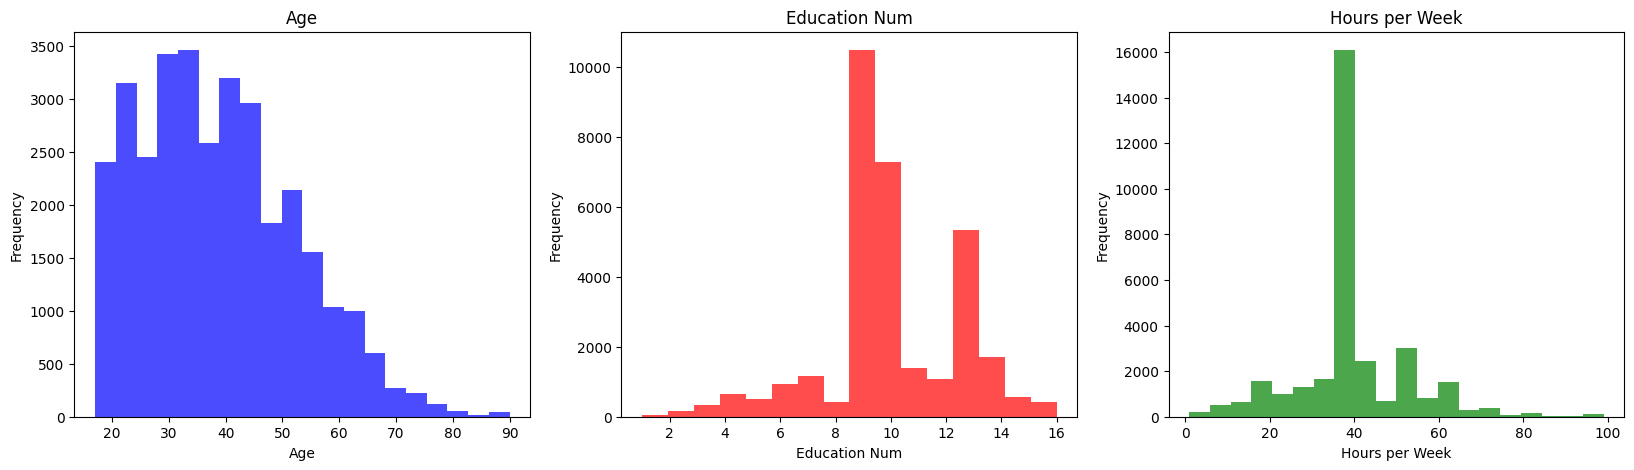

A partir de estos histogramas, notamos que la distribución de edad no es homogénea, lo que nos hace entender que para obtener la información del censo original no se realizó ningún muestreo estratificado, es decir, la información en lo que refiere a la edad mostraría la distribución real de la sociedad en ese momento.

Con respecto a 'Education Num', notamos que gran parte de la población se centra en 9 y 10, lo cual se explica al considerar que la secundaria acaba en el 10mo año de estudios. Además, se identifica otro grupo predominante correspondiente al año 13, que correspondería a bachiller o grado superior.  [[ref](https://www.traveltuition.com/blog/como-es-el-sistema-educativo-en-estados-unidos)]

Con respecto a las horas trabajadas a la semana, notamos que la gran mayoría se encuentra por debajo de las 40 horas; también se identifican outliers con cerca de 100 horas a la semana (que corresponderían a 14 horas al día).


[Benja]

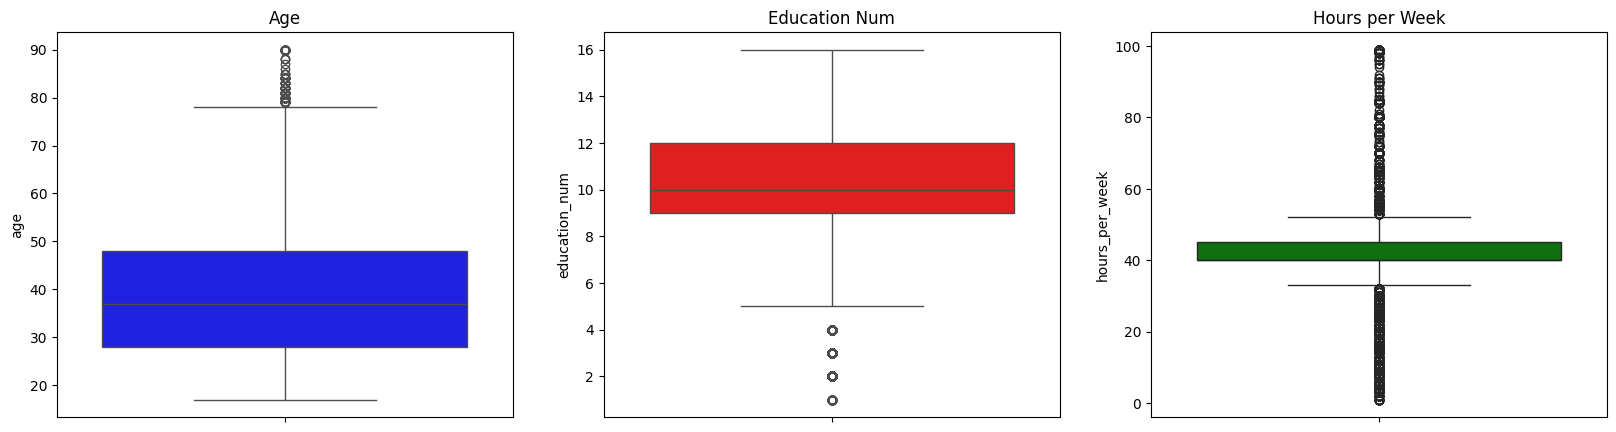

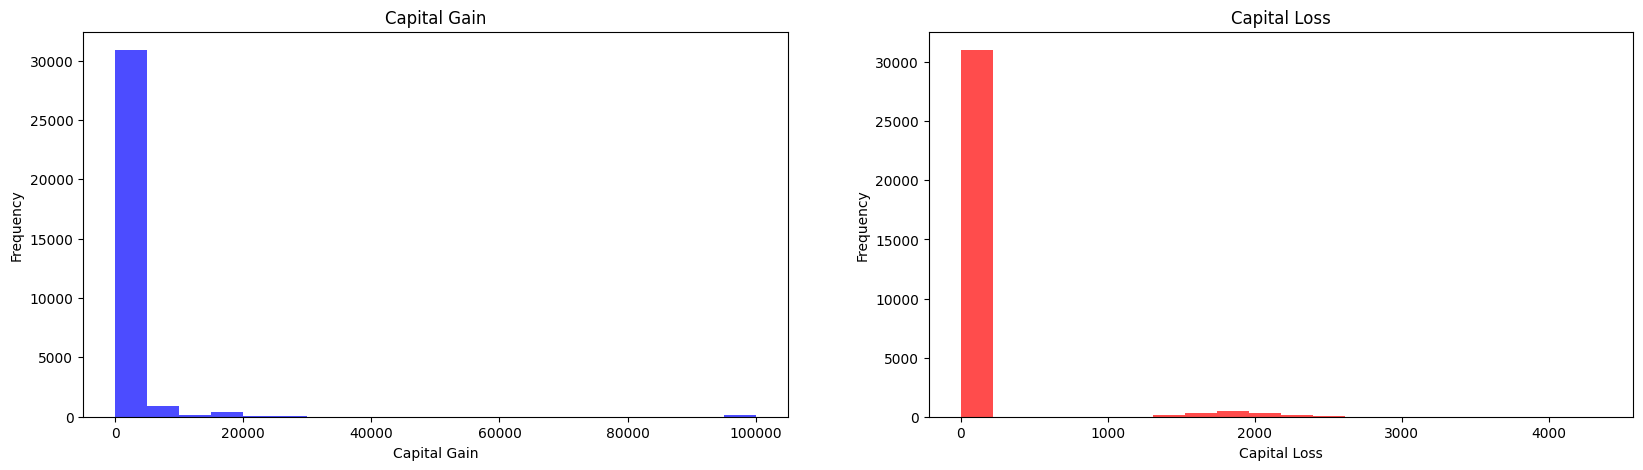

De estos graficos se puede observar un que ambas variables están muy cargadas al cero, además de esto notamos grupos minoritarios con valores positivos, esto podrían ser outliers que podrían eliminarse, sin embargo como equipo se decidió esperar ya que puede que estos valores sean muy determinantes a la hora de desarrollar el modelo y que efectivamente no sean outliers.

[Benja]

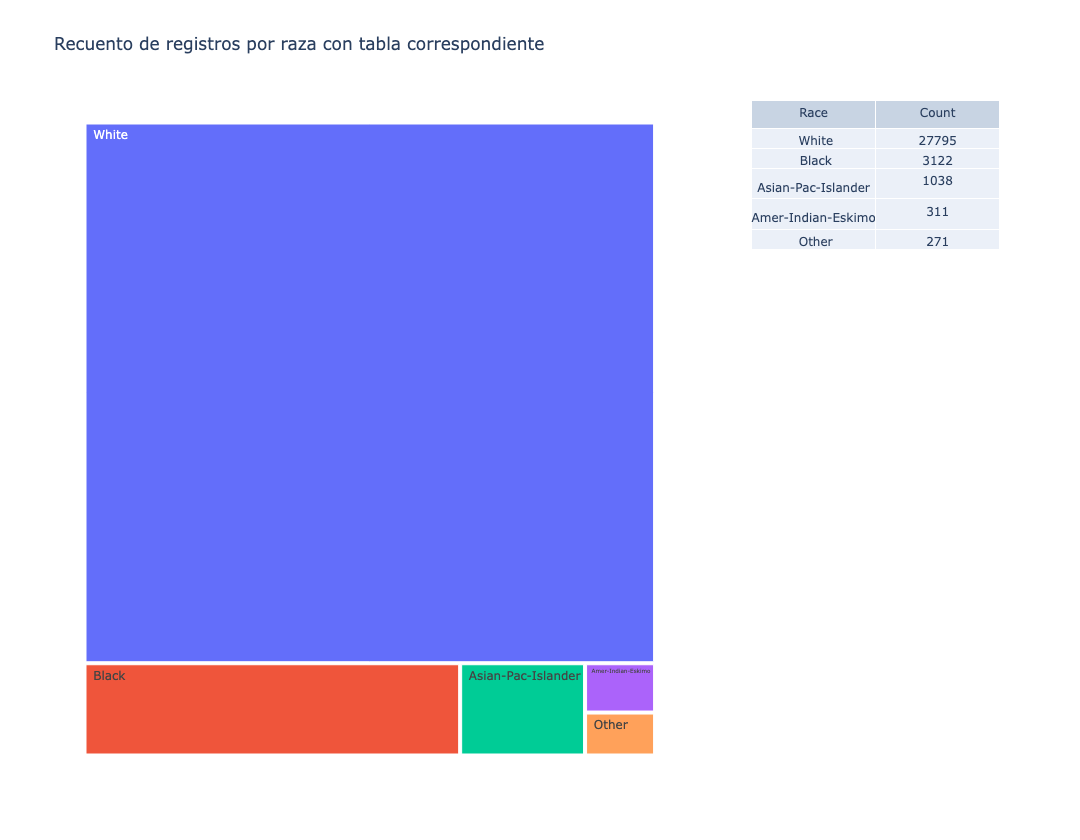

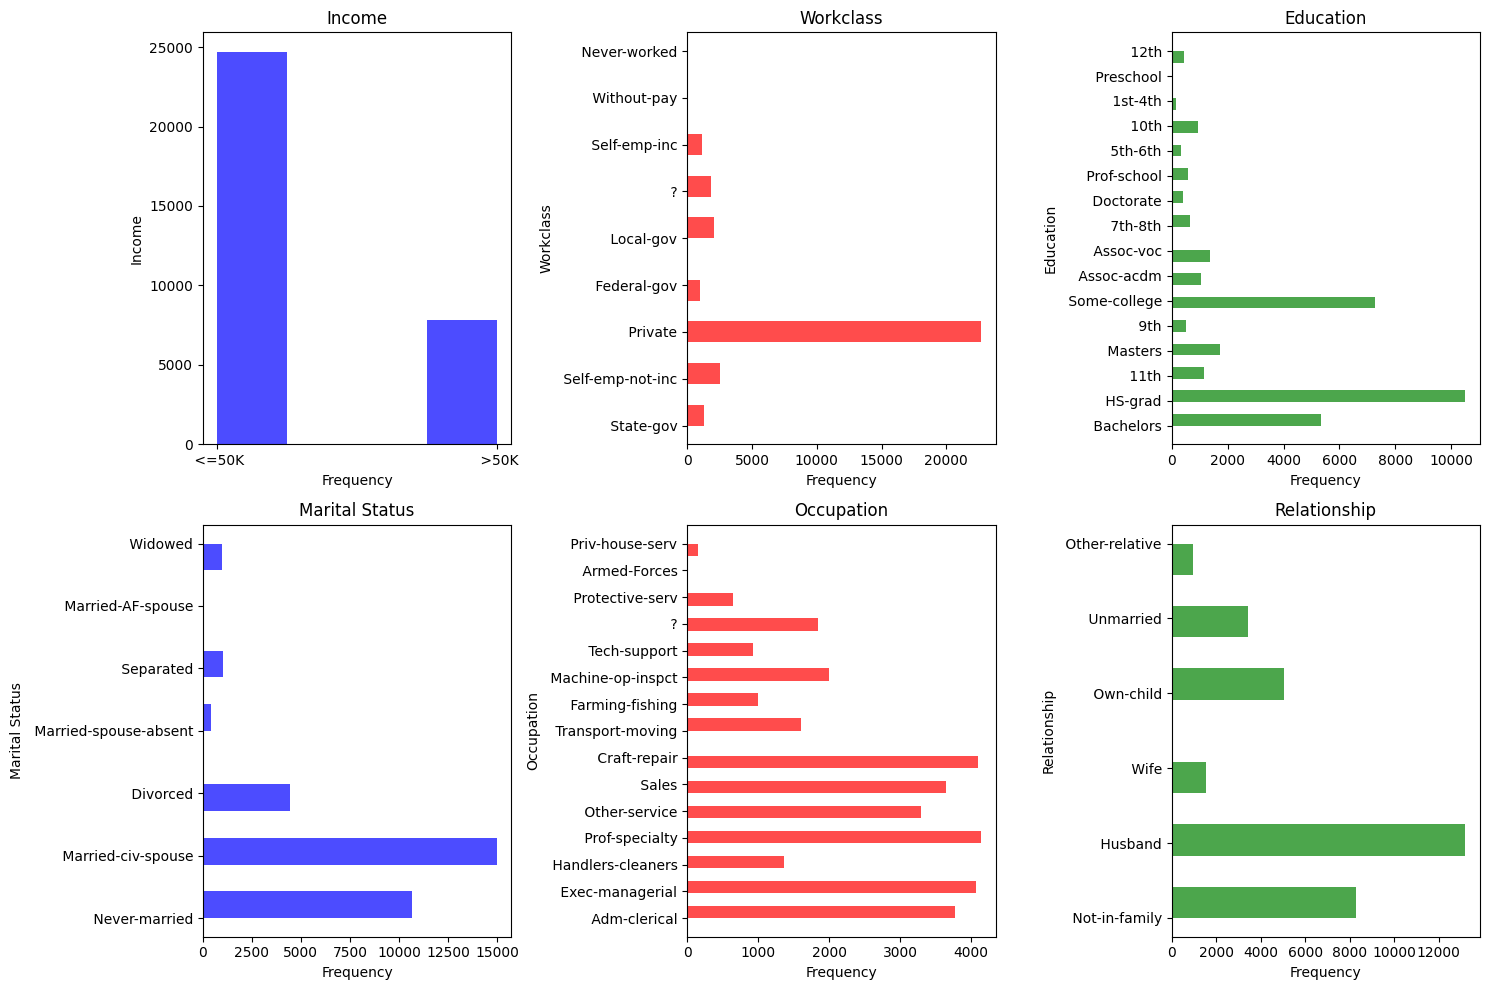

### Graficos multivariados

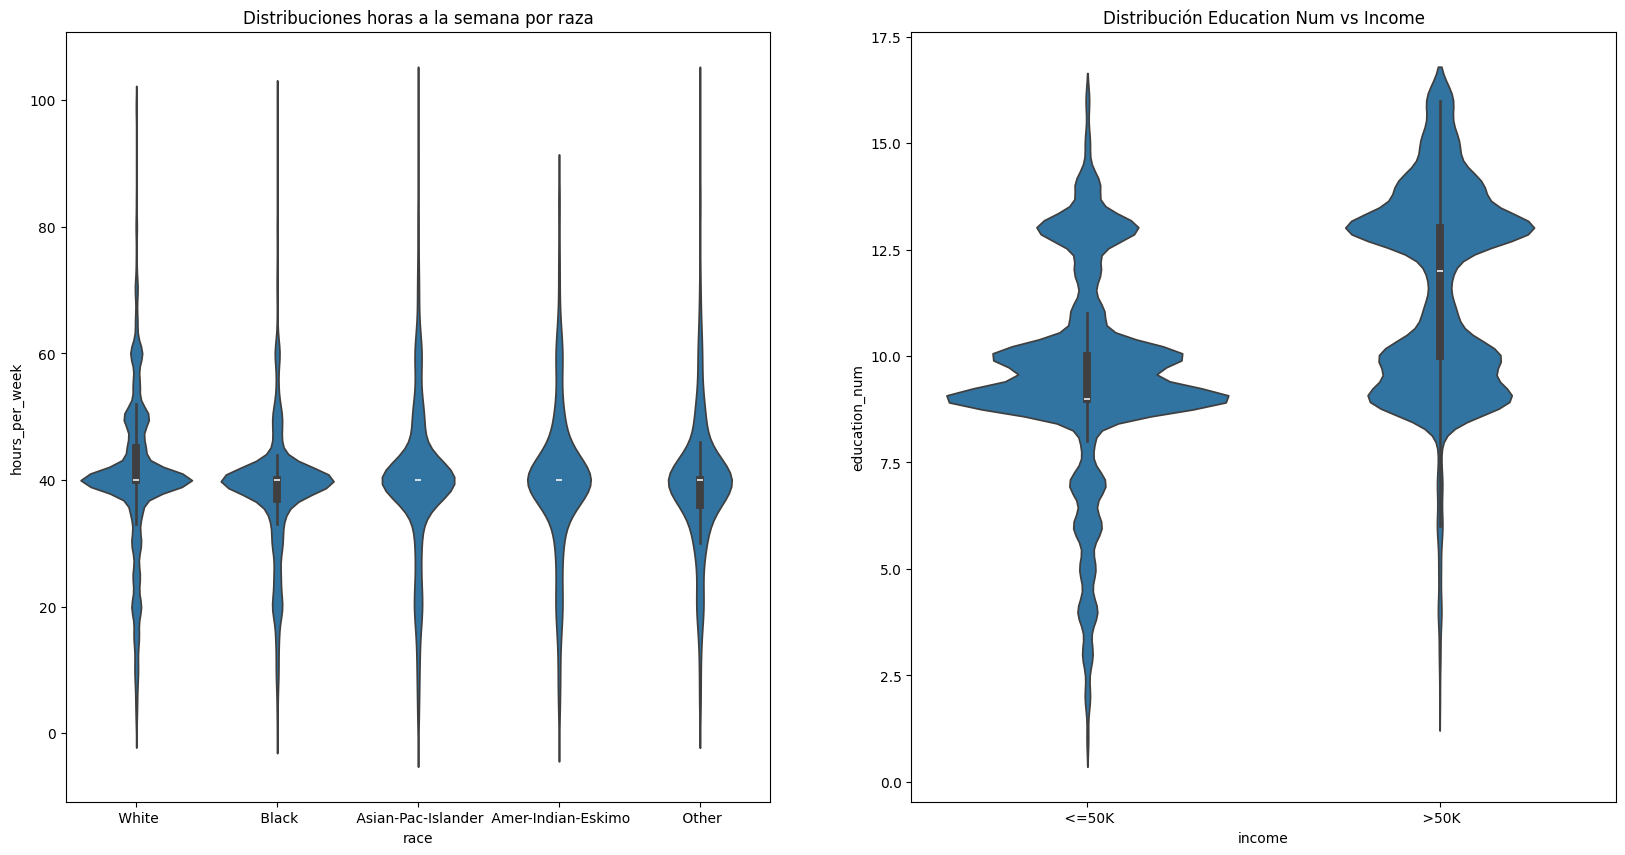

Con respecto al gráfico de education_num vs income, se puede notar una clara diferencia en las distribuciones, siendo la clase '>50K' la que tiene valores de education_num desde 7.5 hacia arriba, con dos grandes grupos. Por el lado de la clase '<=50K', hay una gran parte de la población con education_num entre 8 y 11 aproximadamente.

Con respecto al gráfico de hours_per_week vs race, notamos dos formas predominantes. Una corresponde a las clases 'White' y 'Black', que tienen una moda altamente predominante. Para la segunda forma, tienen modas similares pero se observa una desviación estándar mayor.

[Benja]

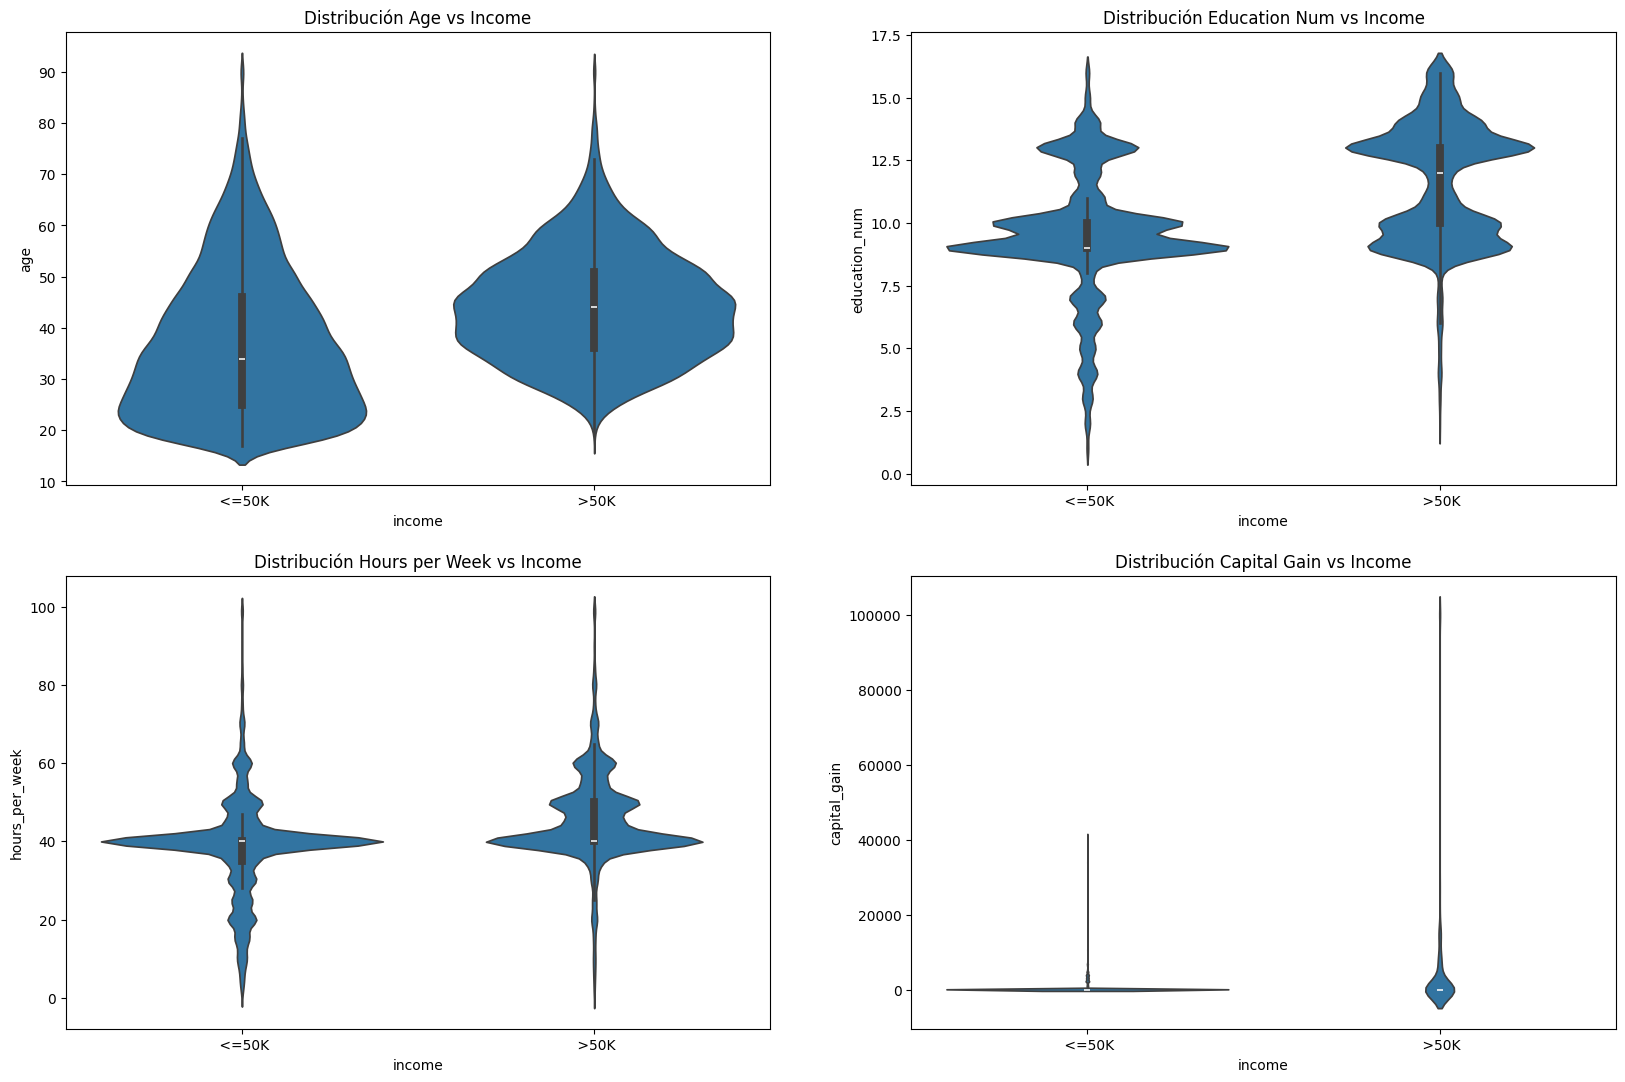

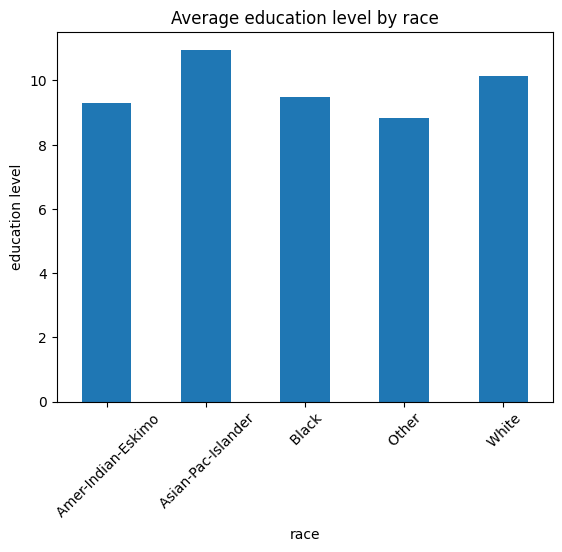

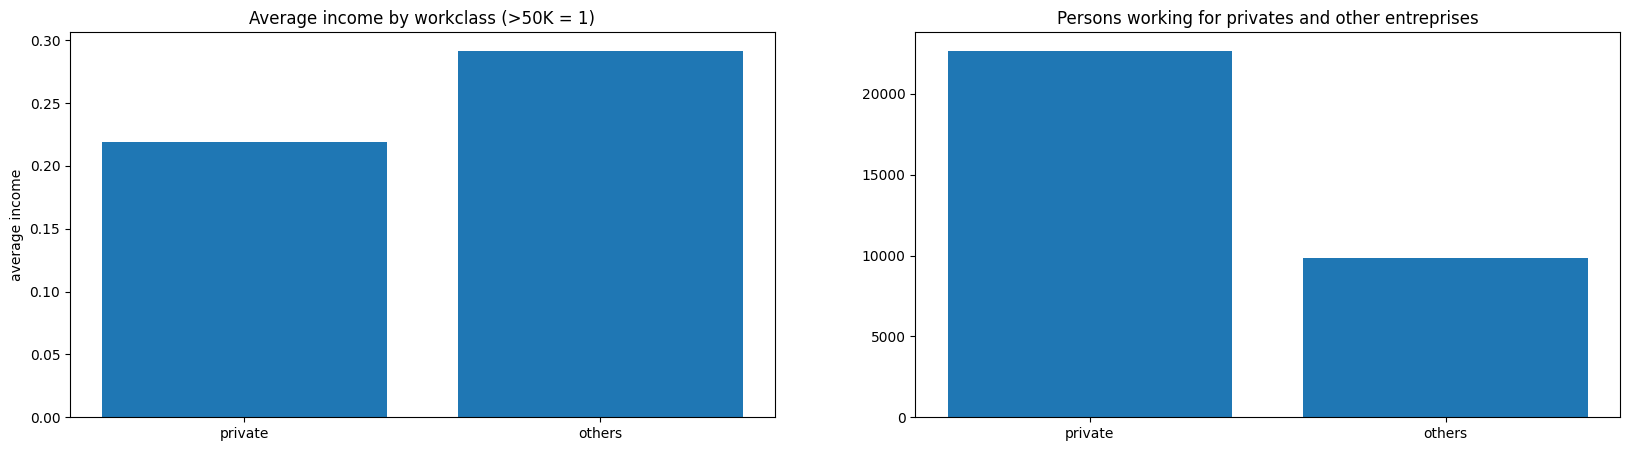

En este gráfico se puede apreciar que, por una parte, en el sector privado el ingreso promedio es menor que en los demás sectores, pero por otra parte, la cantidad de gente que trabaja en ese sector es mucho mayor. Puede deberse a que en el sector privado suele haber más variedad de trabajos, lo que incluye trabajos con una peor remuneración.

[Nico]

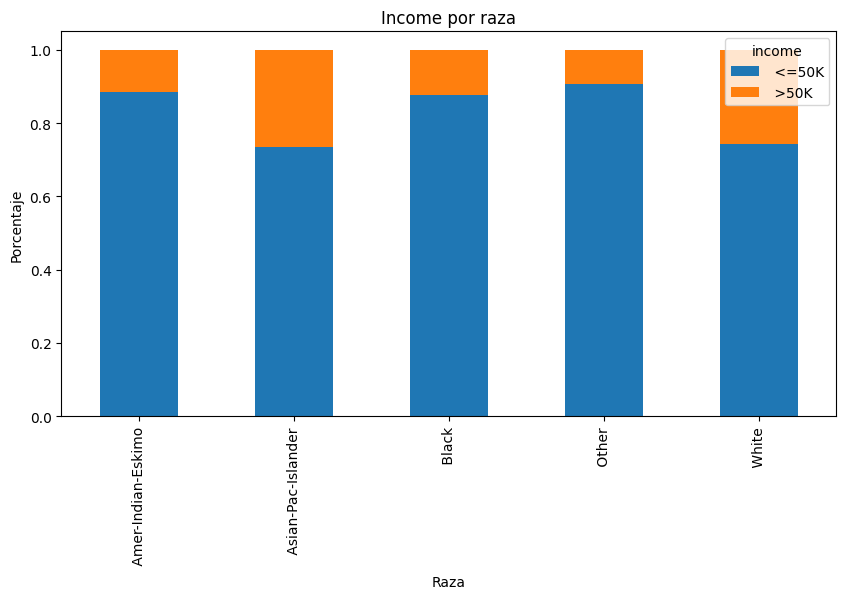

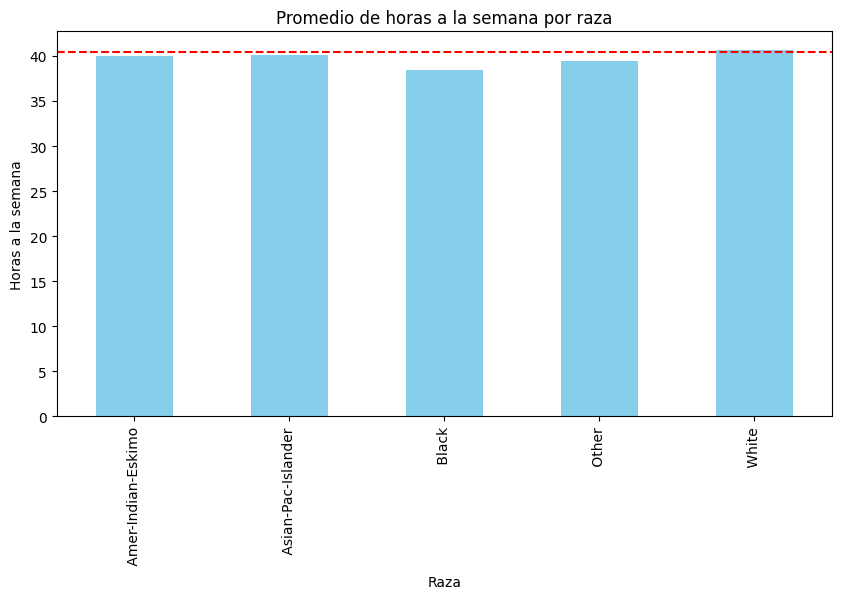

### Matrices de correlación

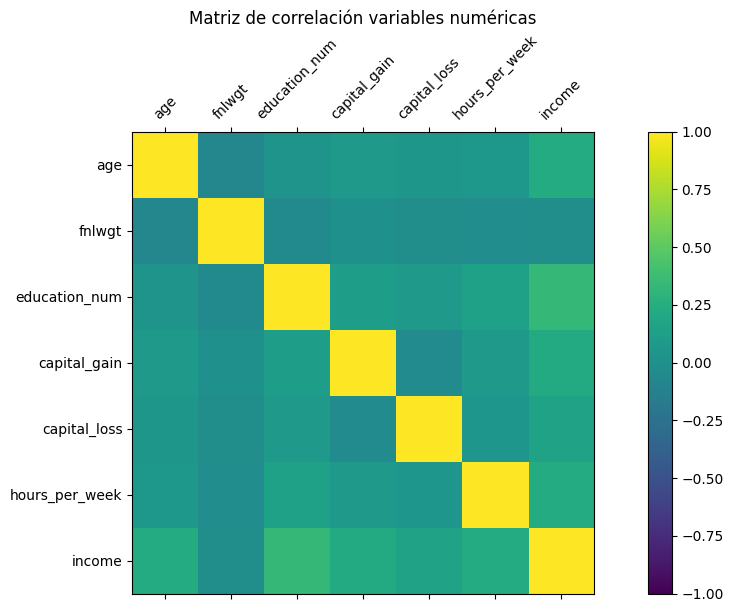

Con respecto a la matriz de correlación, en particular para la variable de interés 'income', observamos principalmente una mayor correlación con 'education_num' y 'age'. Además notamos que no existen variables con correlaciones negativas, lo cual puede deberse al significado naturaleza de las variables (todas positivas)

Para encontrar la dependencia entre las variables categóricas no podemos usar correlación porque estas variables no son continuas. Es por eso que debemos usar el coeficiente V de Cramér, la cual asocia un número entre 0 (no dependientes) y 1 (completamente dependientes) a dos variables discretas.

Consideremos una muestra de tamaño $n$ de dos variables distribuidas simultáneamente $A$ y $B$, cada una con frecuencia $r$ y $k$, respectivamente.
El coeficiente $\chi^2$ corresponde a la prueba Chi Cuadrado de Pearson con la hipótesis nula _Las variables no tienen relación significativa_.

Ya con esto, el coeficiente V de Cramér se calcula por $$V = \sqrt{\frac{\chi^2/n}{\min(k-1, r-1)}}$$

Este coeficiente presenta el problema de ser un estimador sesgado, ya que tiende a sobreestimar la correlación entre las dos variables cuando la cantidad de observaciones es muy grande. Para evitar esto, se busca un menor error de estimación, lo que se logra al realizar la siguiente corrección, que además es la que se usó para encontrar la matriz más adelante: $\begin{align}\tilde{\varphi}^2 &= \max\left(0, \frac{\chi^2}{n} - \frac{(k-1)(r-1)}{n-1}\right) \\ \tilde{k} &= k - \frac{(k-1)^2}{n-1} \\ \tilde{r} &= r - \frac{(r-1)^2}{n-1}\end{align}$

Tomando estas correcciones, el coeficiente V de Cramér se calcula finalmente por: $$\tilde{V} = \sqrt{\frac{\tilde{\varphi}^2}{\min(\tilde{k}-1, \tilde{r}-1)}}$$

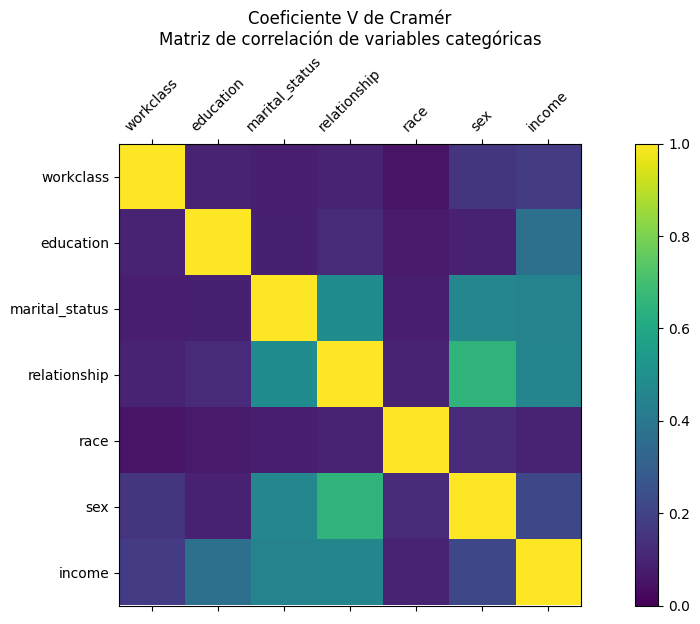

De estas matrices se desprende que la edad, educación y estado marital son las variables más relacionadas al ingreso. La edad está relacionada con la experiencia laboral, el nivel de educación con lo que se requiere para un trabajo mejor remunerado, y el estado marital puede estar relacionado a que, en general, la gente más joven (que gana menos) no está casada, mientras que la gente mayor (ya con experiencia y más estudios, por ende ganando más) si es más probable que esté casada.

[Nico]

## Preguntas


Las preguntas planteadas a continuación se separan en dos partes, las primeras son relacionadas a modelos de clasificación y las segundas a modelos de segmentación. Cada una de las preguntas se aborda con una serie de experimentos que buscan responder a las preguntas planteadas.

### Enfoque en clasiﬁcación

- ¿Cuál es el impacto de descartar las variables sex/race para realizar una predicción/clasificación sobre la variable ‘Income’?

- ¿Se pueden predecir los ingresos utilizando solo las variables que no se pueden cambiar (por ejemplo, edad, raza, sexo)?

-  Experimento: Buscar el mejor clasificador entre Random Forest, SVM Classifier y Naive Bayes, usando todos los atributos. Luego, eliminar sexo/raza de los atributos y contrastar cómo cambian las métricas de clasificación.

- Preprocesamiento: Escalado de variables numericas y codificación de categoricas. Se realizará Oversampling y Subsampling

- Modelos: RF, SVM, NB

### Random Forest

#### Dataset Completo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Random Forest sin remuestreo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest sin remuestreo:")
print(classification_report(y_test, y_pred_rf))

# Oversampling
ros = RandomOverSampler(random_state=42)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
rf_model_over = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_over.fit(X_train_over, y_train_over)
y_pred_over = rf_model_over.predict(X_test)
print("\nRandom Forest con oversampling:")
print(classification_report(y_test, y_pred_over))

# Subsampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
rf_model_under = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_under.fit(X_train_under, y_train_under)
y_pred_under = rf_model_under.predict(X_test)
print("\nRandom Forest con subsampling:")
print(classification_report(y_test, y_pred_under))


Random Forest sin remuestreo:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4942
           1       0.71      0.63      0.67      1571

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.79      6513
weighted avg       0.84      0.85      0.85      6513


Random Forest con oversampling:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4942
           1       0.66      0.70      0.68      1571

    accuracy                           0.84      6513
   macro avg       0.78      0.79      0.79      6513
weighted avg       0.84      0.84      0.84      6513


Random Forest con subsampling:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4942
           1       0.57      0.83      0.67      1571

    accuracy                           0.81      6513
   macro avg       0.75      0.81

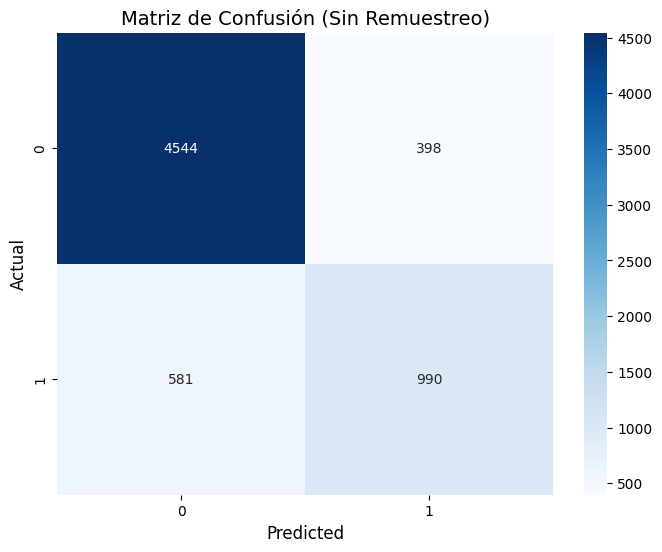

In [ ]:
# Matriz de confusión para Random Forest sin remuestreo
cm_no_resampling = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_no_resampling, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Matriz de Confusión (Sin Remuestreo)", fontsize=14)
plt.show()


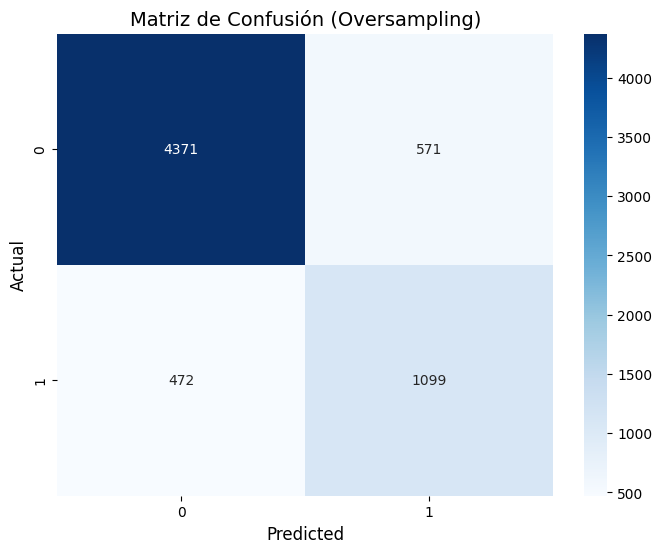

In [ ]:
# Matriz de confusión para Random Forest con oversampling
cm_oversampling = confusion_matrix(y_test, y_pred_over)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_oversampling, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Matriz de Confusión (Oversampling)", fontsize=14)
plt.show()


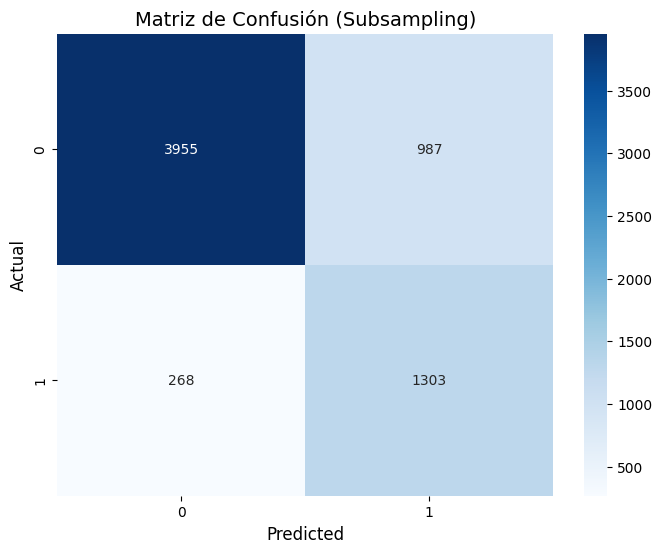

In [ ]:
# Matriz de confusión para Random Forest con subsampling
cm_subsampling = confusion_matrix(y_test, y_pred_under)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_subsampling, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Matriz de Confusión (Subsampling)", fontsize=14)
plt.show()


#### Importancia de las características

In [ ]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Obtener los nombres de las características después de la transformación
feature_names = numerical_columns + list(preprocessor.named_transformers_['encoder'].get_feature_names_out(categorical_columns))

# Crear un DataFrame para mostrar las importancias
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Mostrar las características más importantes
print(feature_importances)


                                 feature  importance
4                                    age    0.228995
2                          education-num    0.132094
1                         hours-per-week    0.115258
0                           capital-gain    0.112124
16     marital-status_Married-civ-spouse    0.088252
36                  relationship_Husband    0.047312
3                           capital-loss    0.035907
25            occupation_Exec-managerial    0.021330
18          marital-status_Never-married    0.019284
31             occupation_Prof-specialty    0.017736
41                     relationship_Wife    0.012065
9                      workclass_Private    0.010719
11            workclass_Self-emp-not-inc    0.009581
48                              sex_Male    0.008761
39                relationship_Own-child    0.008690
37            relationship_Not-in-family    0.008551
46                            race_White    0.007829
33                      occupation_Sales    0.

#### Predicción sin usar los atributos de sexo y raza


In [ ]:
# Dropping 'sex' and 'race' columns for this experiment
X_no_sex_race = X.drop(["sex", "race"], axis=1)

# Splitting the data into train and test sets
X_train_nsr, X_test_nsr, y_train_nsr, y_test_nsr = train_test_split(
    X_no_sex_race, y, test_size=0.2, random_state=42
)

# Preprocessing the data (without 'sex' and 'race')
categorical_columns_nsr = X_no_sex_race.select_dtypes(include=['object']).columns.to_list()
numerical_columns_nsr = list(set(X_no_sex_race.columns) - set(categorical_columns_nsr))

encoder_nsr = OneHotEncoder(sparse_output=False)
scaler_nsr = StandardScaler()
preprocessor_nsr = ColumnTransformer([
    ('scaler', scaler_nsr, numerical_columns_nsr),
    ('encoder', encoder_nsr, categorical_columns_nsr)
])

X_train_nsr = preprocessor_nsr.fit_transform(X_train_nsr)
X_test_nsr = preprocessor_nsr.transform(X_test_nsr)

# Random Forest without resampling (no sex and race)
rf_model_nsr = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_nsr.fit(X_train_nsr, y_train_nsr)
y_pred_rf_nsr = rf_model_nsr.predict(X_test_nsr)
print("Random Forest without resampling (no sex and race):")
print(classification_report(y_test_nsr, y_pred_rf_nsr))

Random Forest without resampling (no sex and race):
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4942
           1       0.71      0.63      0.67      1571

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.84      0.85      0.85      6513



In [ ]:
# Oversampling (no sex and race)
ros_nsr = RandomOverSampler(random_state=42)
X_train_over_nsr, y_train_over_nsr = ros_nsr.fit_resample(X_train_nsr, y_train_nsr)
rf_model_over_nsr = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_over_nsr.fit(X_train_over_nsr, y_train_over_nsr)
y_pred_over_nsr = rf_model_over_nsr.predict(X_test_nsr)
print("\nRandom Forest with oversampling (no sex and race):")
print(classification_report(y_test_nsr, y_pred_over_nsr))


Random Forest with oversampling (no sex and race):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4942
           1       0.66      0.70      0.68      1571

    accuracy                           0.84      6513
   macro avg       0.78      0.79      0.78      6513
weighted avg       0.84      0.84      0.84      6513



In [ ]:
# Subsampling (no sex and race)
rus_nsr = RandomUnderSampler(random_state=42)
X_train_under_nsr, y_train_under_nsr = rus_nsr.fit_resample(X_train_nsr, y_train_nsr)
rf_model_under_nsr = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_under_nsr.fit(X_train_under_nsr, y_train_under_nsr)
y_pred_under_nsr = rf_model_under_nsr.predict(X_test_nsr)
print("\nRandom Forest with subsampling (no sex and race):")
print(classification_report(y_test_nsr, y_pred_under_nsr))


Random Forest with subsampling (no sex and race):
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4942
           1       0.57      0.83      0.68      1571

    accuracy                           0.81      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513



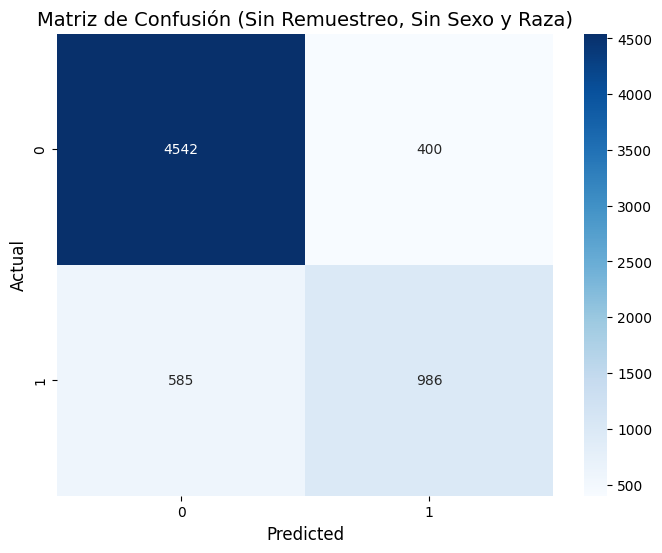

In [ ]:
# Confusion matrix for Random Forest without resampling (no sex and race)
cm_no_resampling_nsr = confusion_matrix(y_test_nsr, y_pred_rf_nsr)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_no_resampling_nsr, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Matriz de Confusión (Sin Remuestreo, Sin Sexo y Raza)", fontsize=14)
plt.show()

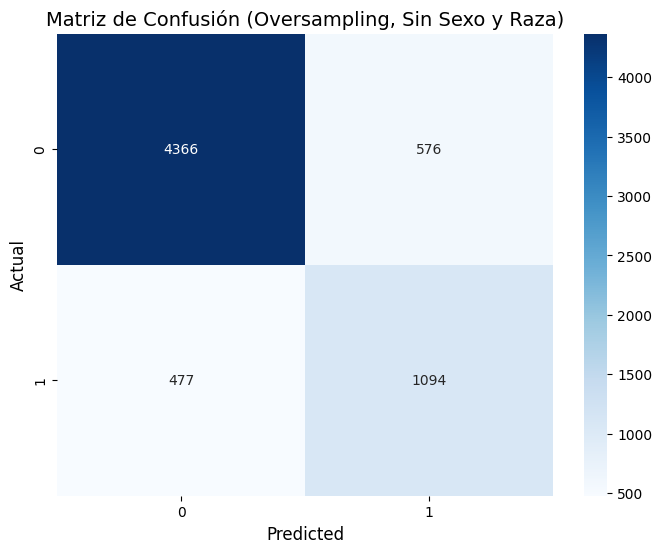

In [ ]:
# Confusion matrix for Random Forest with oversampling (no sex and race)
cm_oversampling_nsr = confusion_matrix(y_test_nsr, y_pred_over_nsr)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_oversampling_nsr, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Matriz de Confusión (Oversampling, Sin Sexo y Raza)", fontsize=14)
plt.show()

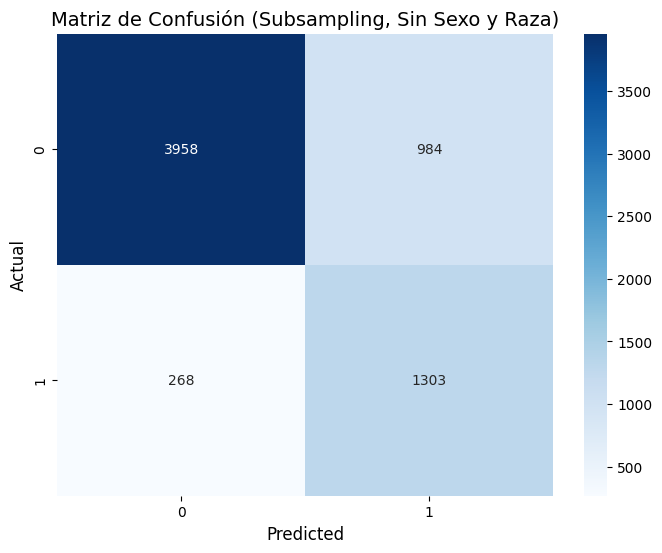

In [ ]:
# Confusion matrix for Random Forest with subsampling (no sex and race)
cm_subsampling_nsr = confusion_matrix(y_test_nsr, y_pred_under_nsr)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_subsampling_nsr, annot=True, fmt="d", ax=ax, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.set_title("Matriz de Confusión (Subsampling, Sin Sexo y Raza)", fontsize=14)
plt.show()

### SVM

#### Dataset Completo

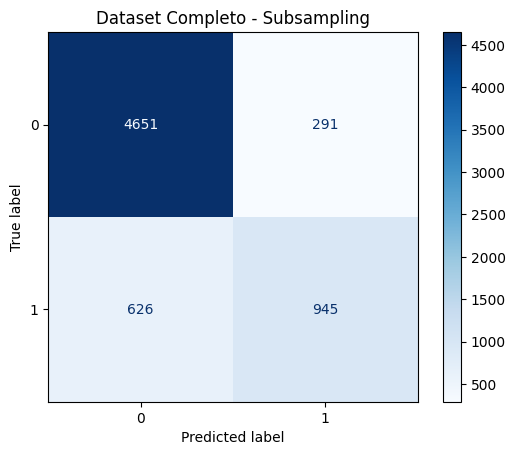

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4942
           1       0.76      0.60      0.67      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education', 'capital-gain' y 'capital-loss'
data.drop(['fnlwgt', 'native-country', 'education'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

#### Eliminando las columnas 'race' y 'sex'

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']


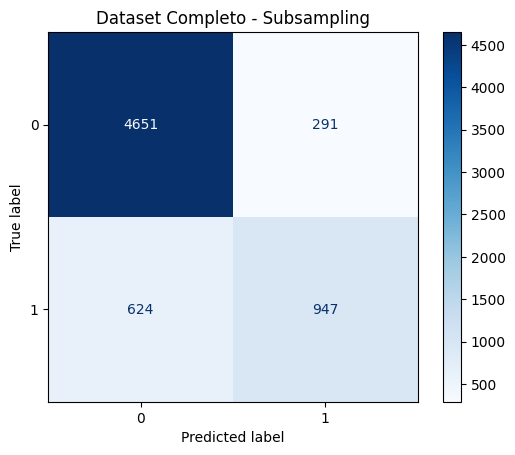

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4942
           1       0.76      0.60      0.67      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education', 'sex' y 'race'
data.drop(['fnlwgt', 'native-country', 'education', 'sex', 'race'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

#### Haciendo Subsampling con el dataset completo

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']


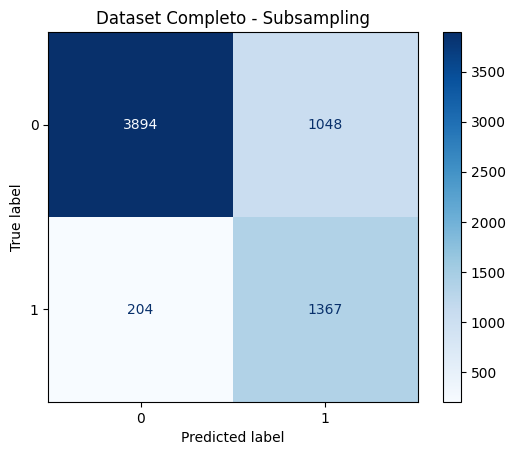

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4942
           1       0.57      0.87      0.69      1571

    accuracy                           0.81      6513
   macro avg       0.76      0.83      0.77      6513
weighted avg       0.86      0.81      0.82      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education'
data.drop(['fnlwgt', 'native-country', 'education'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Undersamplear los datos de entrenamiento
X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

#### Subsampling eliminando las columnas 'race' y 'sex'

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']


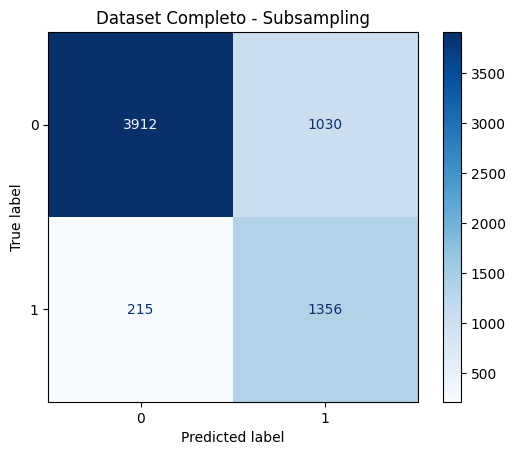

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4942
           1       0.57      0.86      0.69      1571

    accuracy                           0.81      6513
   macro avg       0.76      0.83      0.77      6513
weighted avg       0.86      0.81      0.82      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education', 'sex' y 'race'
data.drop(['fnlwgt', 'native-country', 'education', 'sex', 'race'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Undersamplear los datos de entrenamiento
X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)


# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

#### Oversampling con dataset completo

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']


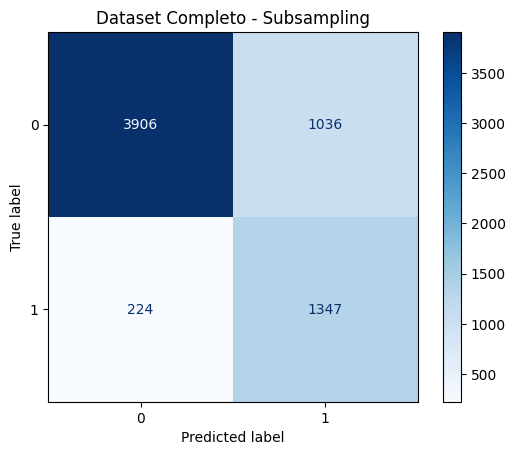

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4942
           1       0.57      0.86      0.68      1571

    accuracy                           0.81      6513
   macro avg       0.76      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education'
data.drop(['fnlwgt', 'native-country', 'education'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversamplear el conjunto de entrenamiento
smote = SMOTENC(categorical_features=[col in categorical_columns for col in X_train.columns], random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

#### Oversampling eliminando columnas 'race' y 'sex'

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']


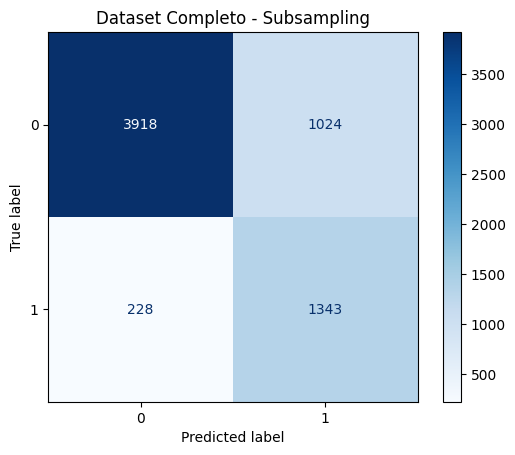

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4942
           1       0.57      0.85      0.68      1571

    accuracy                           0.81      6513
   macro avg       0.76      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education', 'sex', 'race'
data.drop(['fnlwgt', 'native-country', 'education', 'sex', 'race'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversamplear el conjunto de entrenamiento
smote = SMOTENC(categorical_features=[col in categorical_columns for col in X_train.columns], random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

Notemos que, dada la proporción 3:1 de las clases '0' y '1', aplicar `subsampling` elimina demasiados datos, mientras que aplicar `oversampling` crea demasiados datos artificiales. Por ello, se probará aplicando ambas estrategias

#### Subsampling y Oversampling dataset completo

In [ ]:
def count_files(X, y) -> dict:
    output = {}
    output['0'] = len(X[y == 0])
    output['1'] = len(X[y == 1])
    assert output['0'] + output['1'] == len(X)
    return output

# [Nico]

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']
Filas por clase antes: {'0': 19778, '1': 6270}
Filas por clase después del Undersampling: {'0': 12540, '1': 6270}
Filas por clase después del Oversampling: {'0': 12540, '1': 12540}


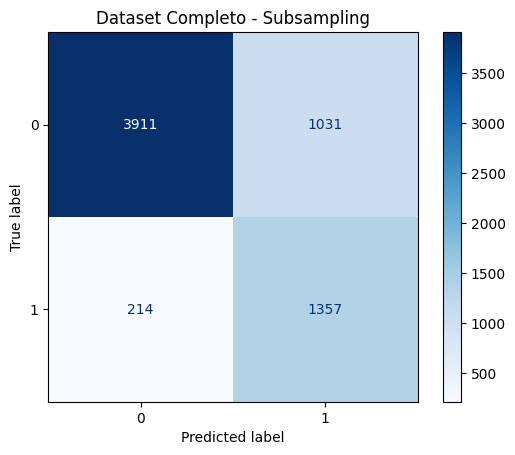

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4942
           1       0.57      0.86      0.69      1571

    accuracy                           0.81      6513
   macro avg       0.76      0.83      0.77      6513
weighted avg       0.86      0.81      0.82      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education'
data.drop(['fnlwgt', 'native-country', 'education'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Filas por clase antes: {count_files(X_train, y_train)}")

# Undersampling de la clase '0'
X_train, y_train = RandomUnderSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)

print(f"Filas por clase después del Undersampling: {count_files(X_train, y_train)}")

# Oversampling de la clase '1'
smote = SMOTENC(categorical_features=[col in categorical_columns for col in X_train.columns], random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Filas por clase después del Oversampling: {count_files(X_train, y_train)}")

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

#### Subsampling y Oversampling eliminando columnas 'race' y 'sex'

categorical_columns = ['workclass', 'marital-status', 'occupation', 'relationship']
numerical_columns = ['capital-loss', 'education-num', 'age', 'hours-per-week', 'capital-gain']
Filas por clase antes: {'0': 19778, '1': 6270}
Filas por clase después del Undersampling: {'0': 12540, '1': 6270}
Filas por clase después del Oversampling: {'0': 12540, '1': 12540}


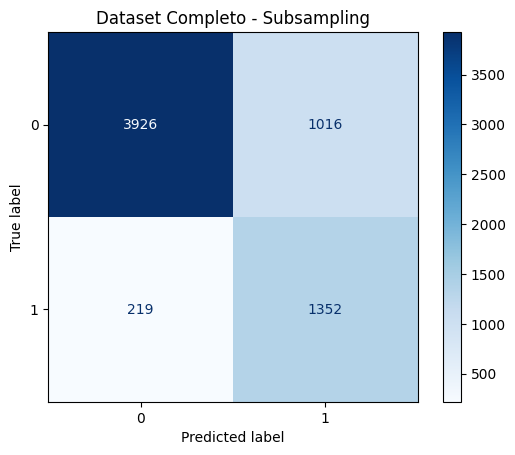

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4942
           1       0.57      0.86      0.69      1571

    accuracy                           0.81      6513
   macro avg       0.76      0.83      0.78      6513
weighted avg       0.86      0.81      0.82      6513



In [ ]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]
data = pd.read_csv(url, names=columns, na_values=" ?", skipinitialspace=True)

# Preprocesamiento: Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Dropear columnas 'fnlwgt', 'native-country', 'education', 'race', 'sex'
data.drop(['fnlwgt', 'native-country', 'education', 'race', 'sex'], axis=1, inplace=True)

# Separar características y la variable objetivo
X = data.drop("income", axis=1)
y = data["income"].map({'>50K': 1, '<=50K': 0})
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(f"{categorical_columns = }")
print(f"{numerical_columns = }")

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Filas por clase antes: {count_files(X_train, y_train)}")

# Undersampling de la clase '0'
X_train, y_train = RandomUnderSampler(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)

print(f"Filas por clase después del Undersampling: {count_files(X_train, y_train)}")

# Oversampling de la clase '1'
smote = SMOTENC(categorical_features=[col in categorical_columns for col in X_train.columns], random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Filas por clase después del Oversampling: {count_files(X_train, y_train)}")

# Preprocesar los datos
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_columns),
    ('encoder', encoder, categorical_columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



svc = SVC(random_state=42)
svc = svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Dataset Completo - Subsampling")
plt.show()
print(classification_report(y_test, y_pred))

# [Nico]

### Enfoque de segmentación

In [ ]:
from aux_clustering import*

/Users/benjamin/Documents/GitHub/Proyecto_mineria_cc5205/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- ¿se pueden obtiener clusters con alta pureza?
- ¿Cómo cambia el número de clusters óptimos al excluir variables que no se pueden modificar?

- Experimento: Realizar segmentación con distintos modelos, identificando su número de clusters óptimo. Luego modificar las variables de entrada y analizar como varía dicho número.
- Preprocesamiento: Escalado de variables numéricas y codificación de categóricas.

- Modelos: K-Means, Método jerárquico aglomerativo, Gaussian Mixture


In [ ]:
# import data
df_clustering = pd.read_csv('adult.data.csv', header=None)
df_clustering.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
df_clustering.dropna(inplace=True)

# drop columnas que no nos interesan
df_clustering.drop(['fnlwgt', 'native_country', 'education'], axis=1, inplace=True)

# segmentacion de columnas
num_cols = df_clustering.select_dtypes(include=['int64']).columns
cat_cols = df_clustering.select_dtypes(include=['object']).columns

# [Benja]

In [ ]:
# preprocesamiento

df_full = df_clustering.copy().sample(1000, random_state=42)
df_full_scaled = preprocess(df = df_full,
                            scaler_method_name ='PowerTransform',
                            numerical_cols = num_cols,
                            encoder_method_name = 'OneHotEncoder',
                            categorical_cols = cat_cols)

df_reduced = df_clustering.copy().sample(1000, random_state=42)
df_reduced.drop(['sex', 'race'], axis=1, inplace=True)
df_reduced_scaled = preprocess(df = df_reduced,
                            scaler_method_name ='PowerTransform',
                            numerical_cols = num_cols,
                            encoder_method_name = 'OneHotEncoder',
                            categorical_cols = cat_cols)

# [Benja]

# Dataset Completo

A continuación se realizará el analisis del metodo del codo con KMeans, el cual nos permitirá encontrar el número de clusters óptimo para el dataset completo.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


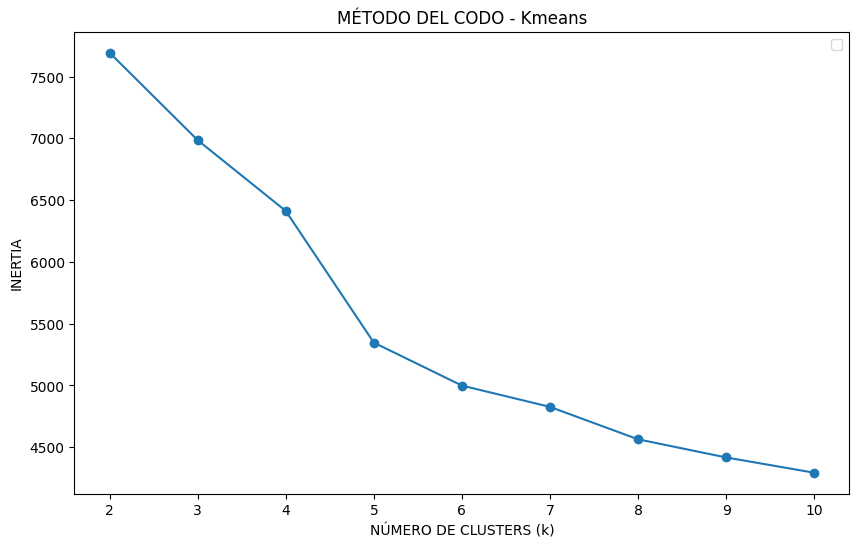

In [ ]:
# Kmeans Clustering elbow
model = 'Kmeans'
dataset = 'Full'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)

# metodo de silhouete score
k_means_elbow(df = df_full_scaled, model_name = model, output_file_path = output_path + '/elbow.png')

# [Lucas]

Metricas para Kmeans
Silhouette Score: 0.1677996400196816
Davies-Bouldin Index: 1.8742808049135937
Calinski-Harabasz Index: 163.9421022414014

Cantidad de datos por cluster:
Cluster 0: 298 datos
Cluster 1: 50 datos
Cluster 2: 243 datos
Cluster 3: 314 datos
Cluster 4: 95 datos


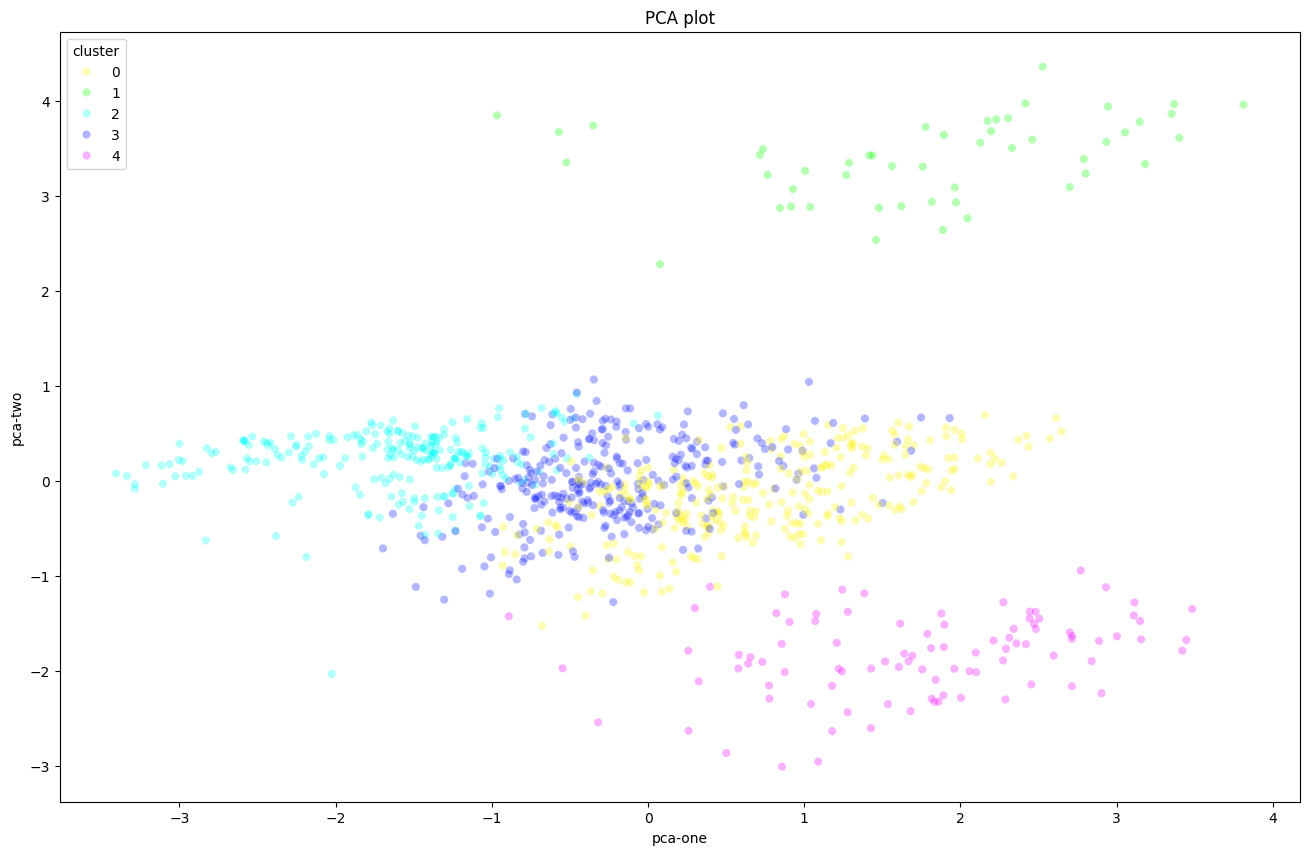

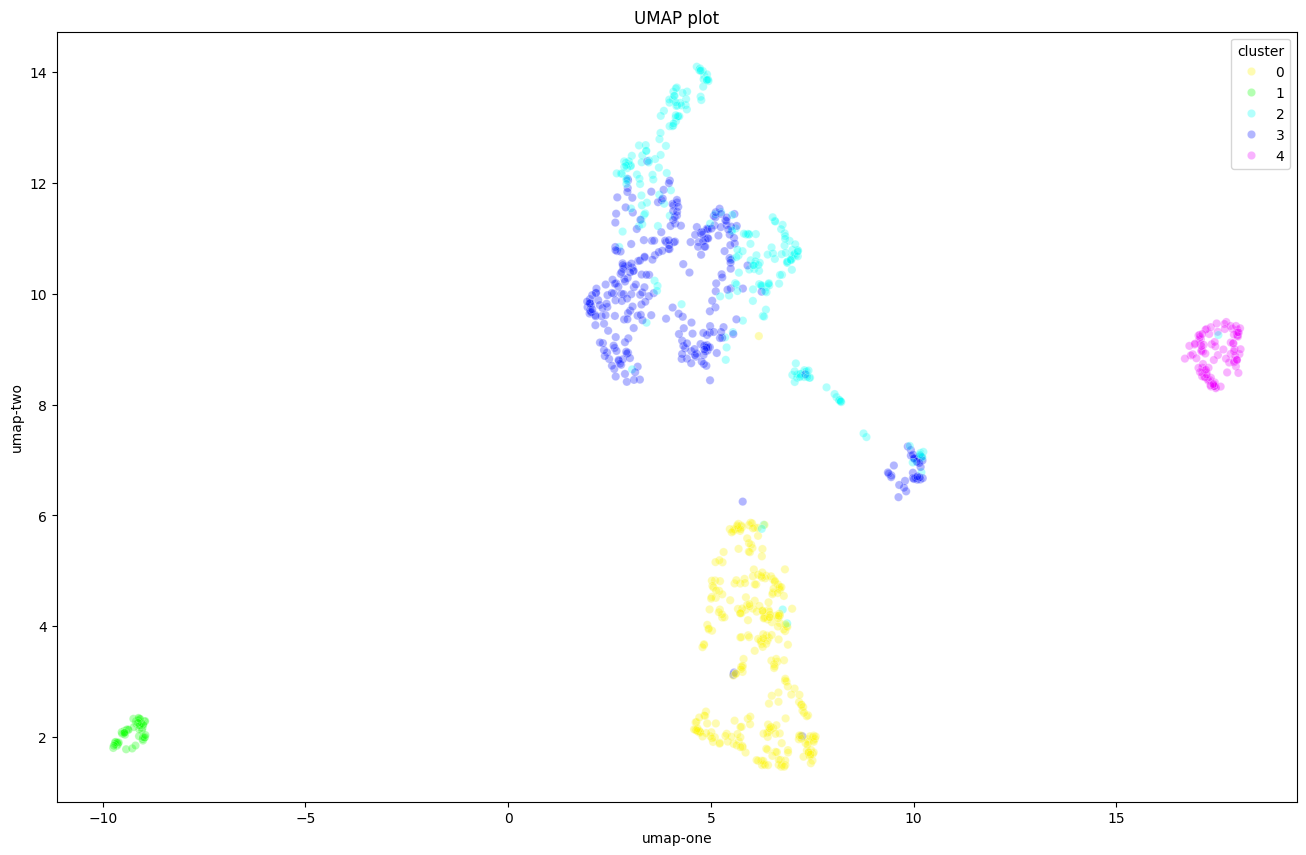

In [ ]:
# Valor optimo segun grafico
model = 'Kmeans'
dataset = 'Full'
output_path = 'resultados/' + dataset + '_' + model

k_optimo = 5

# clustering
df_full_clustered, df_full_scaled_clustered = get_clusters(df_full, df_full_scaled,model,k_optimo)

# metricas
get_metrics(df_full_scaled_clustered, model)

# visualizaciones
plot_PCA(df_full_scaled_clustered, output_path + '/pca')
plot_UMAP(df_full_scaled_clustered, output_path + '/umap')

# [Lucas]

En la siguiente parte se realiza el entrenamiento con 3 modelos distintos, los cuales buscan el numero optimo de clusters basados en el Silhouette Score.

Silhouette score visualization saved
Metricas para Kmeans
Silhouette Score: 0.1677996400196816
Davies-Bouldin Index: 1.8742808049135937
Calinski-Harabasz Index: 163.9421022414014

Cantidad de datos por cluster:
Cluster 0: 298 datos
Cluster 1: 50 datos
Cluster 2: 243 datos
Cluster 3: 314 datos
Cluster 4: 95 datos


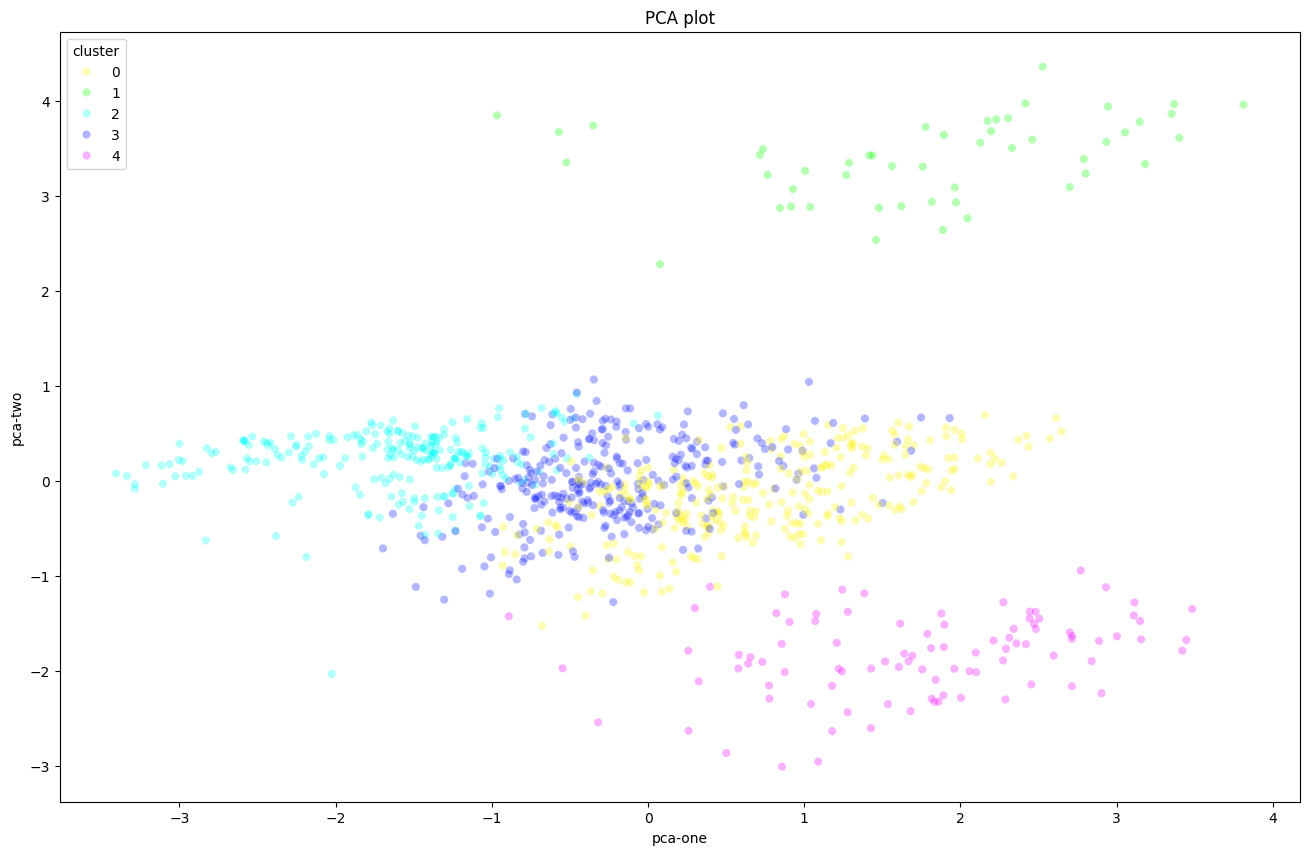

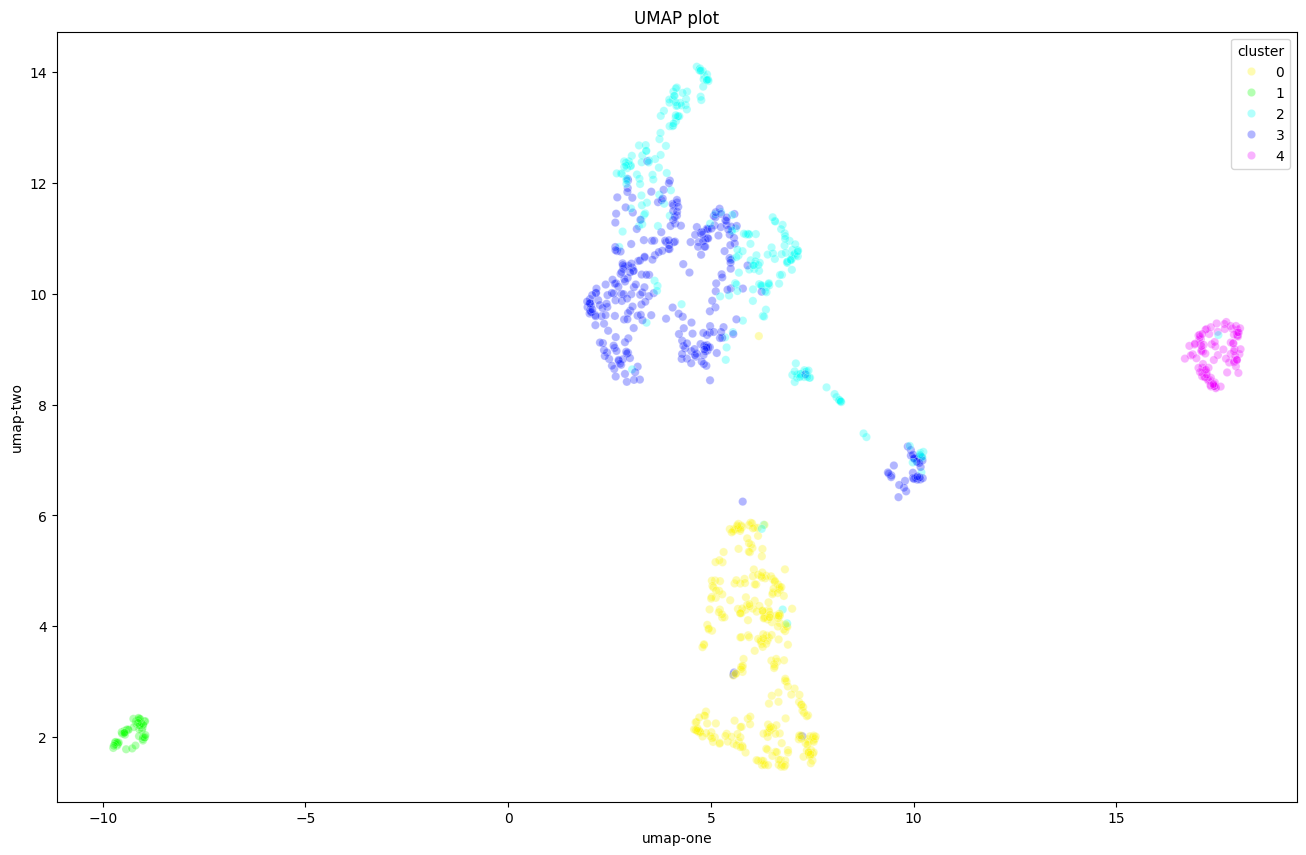

In [ ]:
# Kmeans Clustering Silhouette

model = 'Kmeans'
dataset = 'Full'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)


# metodo de silhouete score
k_optimo = silhoutte_method(df = df_full_scaled, model_name = model, output_file_path = output_path + '/silhouette.png')

# clustering
df_full_clustered, df_full_scaled_clustered = get_clusters(df_full, df_full_scaled,model,k_optimo)

# metricas
get_metrics(df_full_scaled_clustered, model)

# visualizaciones
plot_PCA(df_full_scaled_clustered, output_path + '/pca')
plot_UMAP(df_full_scaled_clustered, output_path + '/umap')

# [Benja]

Silhouette score visualization saved
Metricas para Agglomerative
Silhouette Score: 0.292052183725219
Davies-Bouldin Index: 1.275614270349166
Calinski-Harabasz Index: 157.2257614043592

Cantidad de datos por cluster:
Cluster 0: 856 datos
Cluster 1: 94 datos
Cluster 2: 50 datos


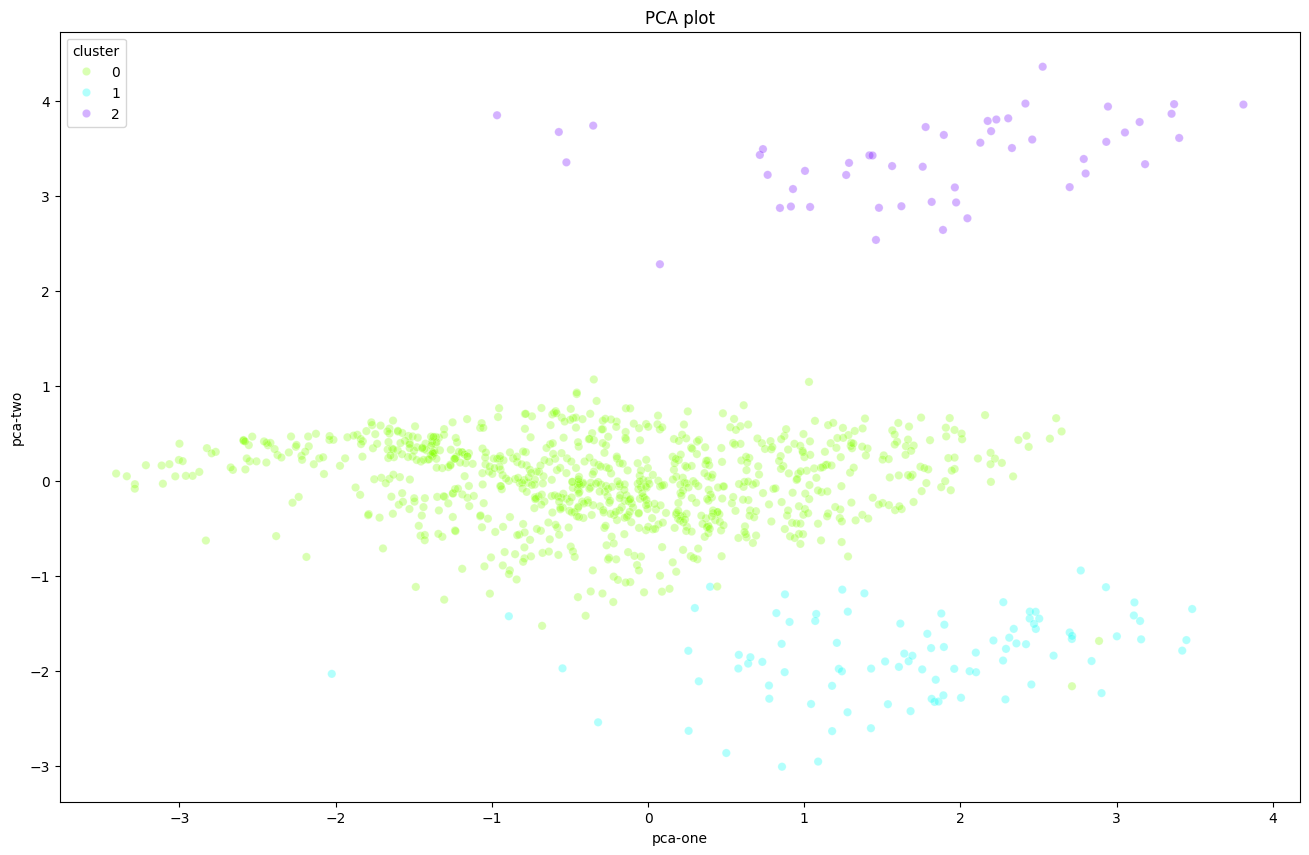

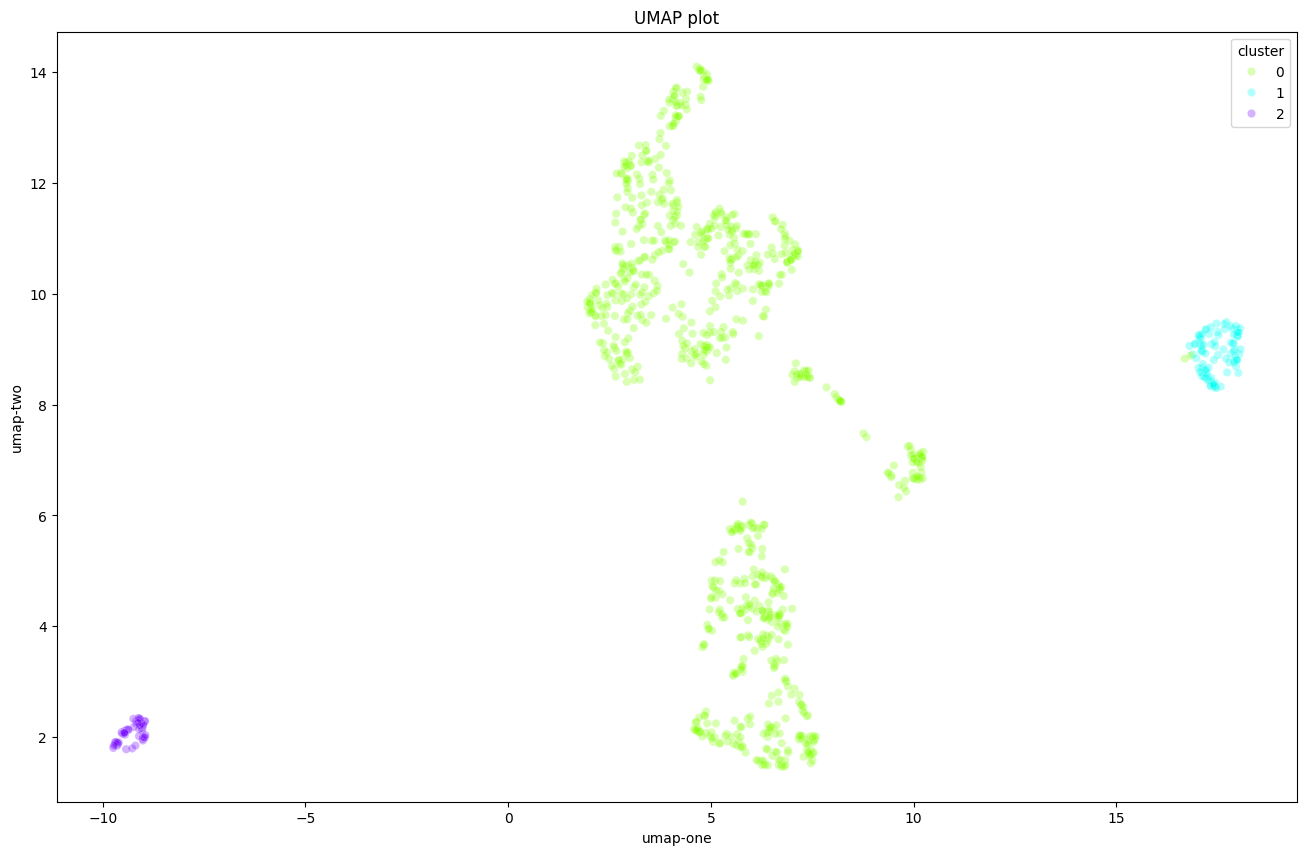

In [ ]:
# Agglomerative Clustering

model = 'Agglomerative'
dataset = 'Full'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)


# metodo de silhouete score
k_optimo = silhoutte_method(df = df_full_scaled, model_name = model, output_file_path = output_path + '/silhouette.png')

# clustering
df_full_clustered, df_full_scaled_clustered = get_clusters(df_full, df_full_scaled, model, k_optimo)

# metricas
get_metrics(df_full_scaled_clustered, model)

# visualizaciones
plot_PCA(df_full_scaled_clustered, output_path + '/pca')
plot_UMAP(df_full_scaled_clustered, output_path + '/umap')

# [Benja]

Silhouette score visualization saved
Metricas para GaussianMixture
Silhouette Score: 0.14788926388066062
Davies-Bouldin Index: 2.693498437950285
Calinski-Harabasz Index: 136.2332148683164

Cantidad de datos por cluster:
Cluster 0: 299 datos
Cluster 1: 50 datos
Cluster 2: 393 datos
Cluster 3: 162 datos
Cluster 4: 96 datos


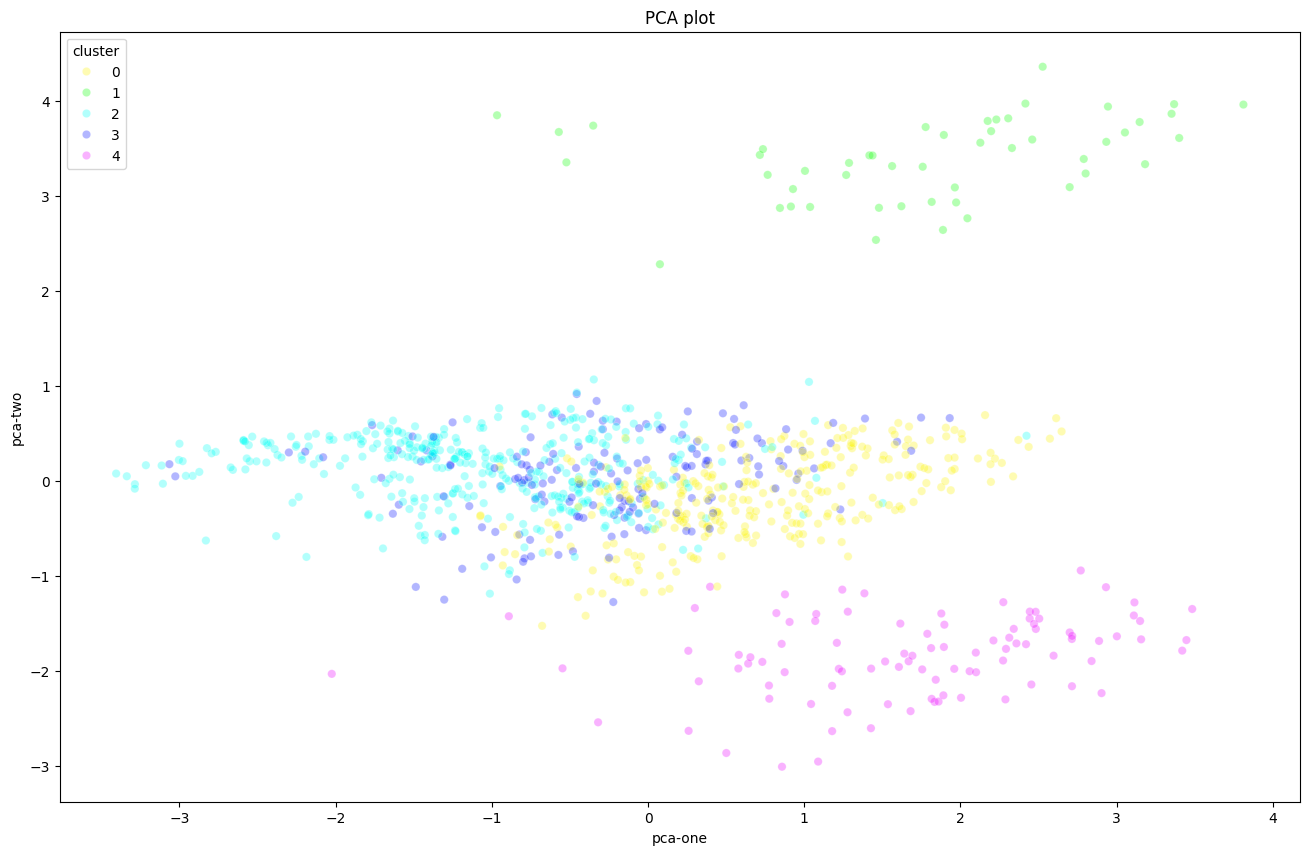

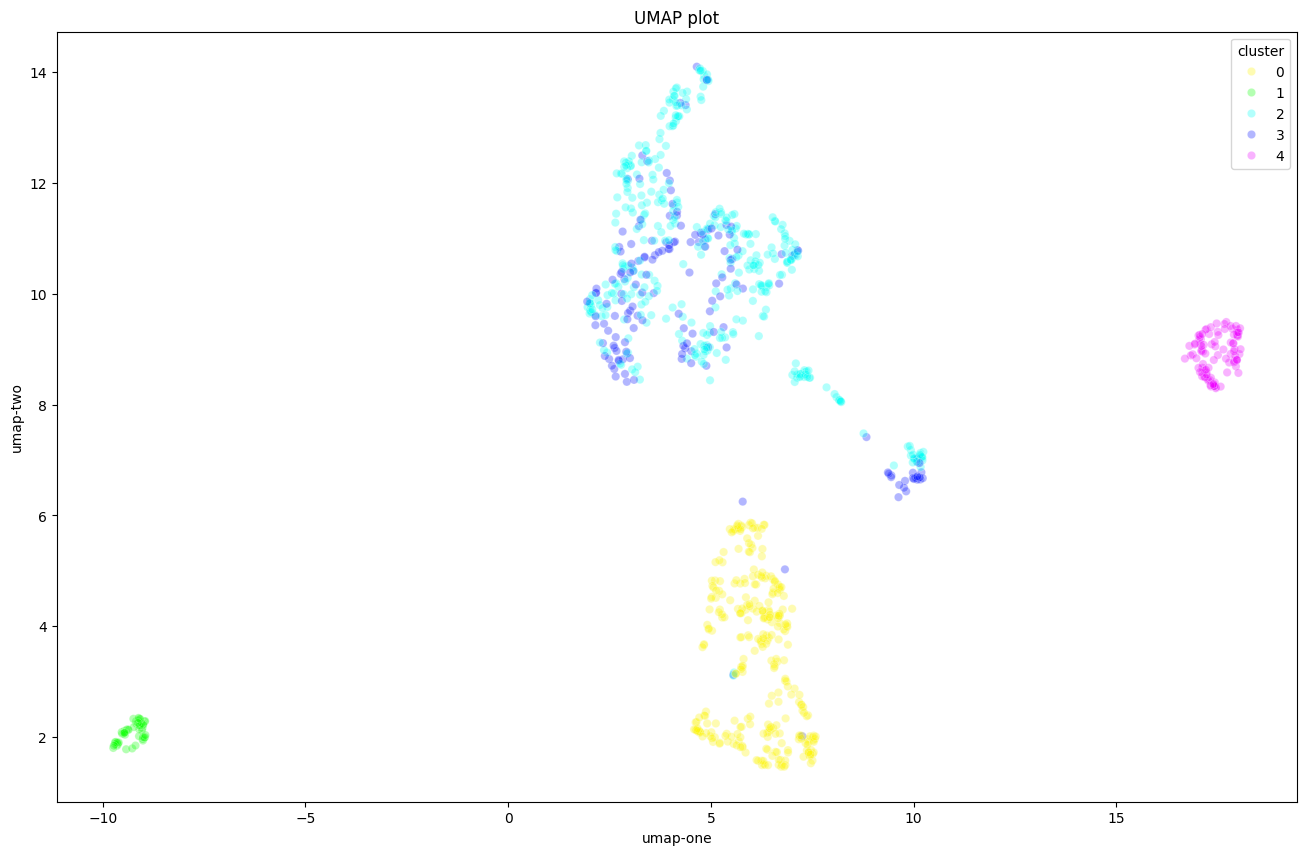

In [ ]:
# GaussianMixture Clustering

model = 'GaussianMixture'
dataset = 'Full'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)


# metodo de silhouete score
k_optimo = silhoutte_method(df = df_full_scaled, model_name = model, output_file_path = output_path + '/silhouette.png')

# clustering
df_full_clustered, df_full_scaled_clustered = get_clusters(df_full, df_full_scaled, model, k_optimo)

# metricas
get_metrics(df_full_scaled_clustered, model)

# visualizaciones
plot_PCA(df_full_scaled_clustered, output_path + '/pca')
plot_UMAP(df_full_scaled_clustered, output_path + '/umap')

# [Benja]

Con respecto a las métricas de segmentación y basandonos principalmente en el Silhouette Score, notamos que el método jerárquico aglomerativo es el que mejor se comporta, con un número de clusters óptimo de 3. Al visualizar los clusters, notamos que estos están bien definidos y que la pureza es alta.

[Benja]

# Dataset Reducido

A continuación se realizará el analisis del metodo del codo con KMeans, el cual nos permitirá encontrar el número de clusters óptimo para el dataset completo.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


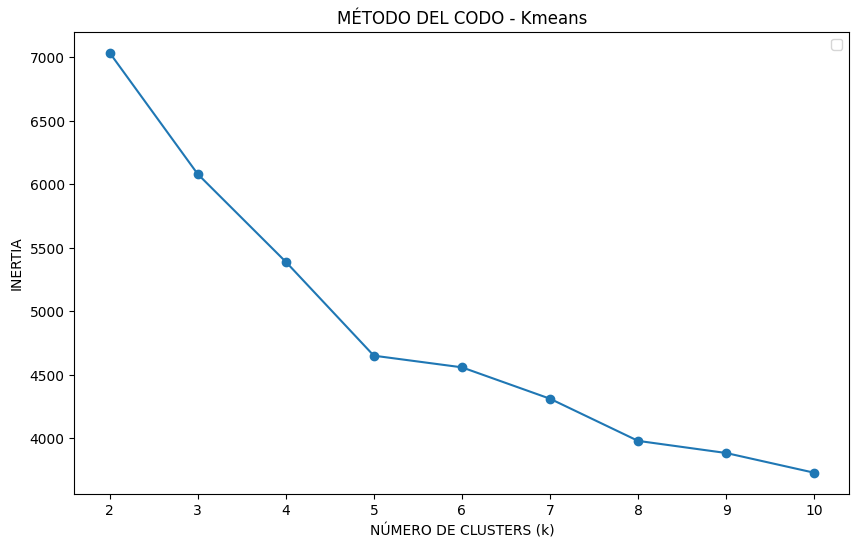

In [ ]:
# Kmeans Clustering elbow
model = 'Kmeans'
dataset = 'Reduced'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)

# metodo de silhouete score
k_means_elbow(df = df_reduced_scaled, model_name = model, output_file_path = output_path + '/elbow.png')

# [Lucas]

Metricas para Kmeans
Silhouette Score: 0.1781675141749086
Davies-Bouldin Index: 1.6857823880362495
Calinski-Harabasz Index: 188.12404556174562

Cantidad de datos por cluster:
Cluster 0: 217 datos
Cluster 1: 333 datos
Cluster 2: 50 datos
Cluster 3: 304 datos
Cluster 4: 96 datos


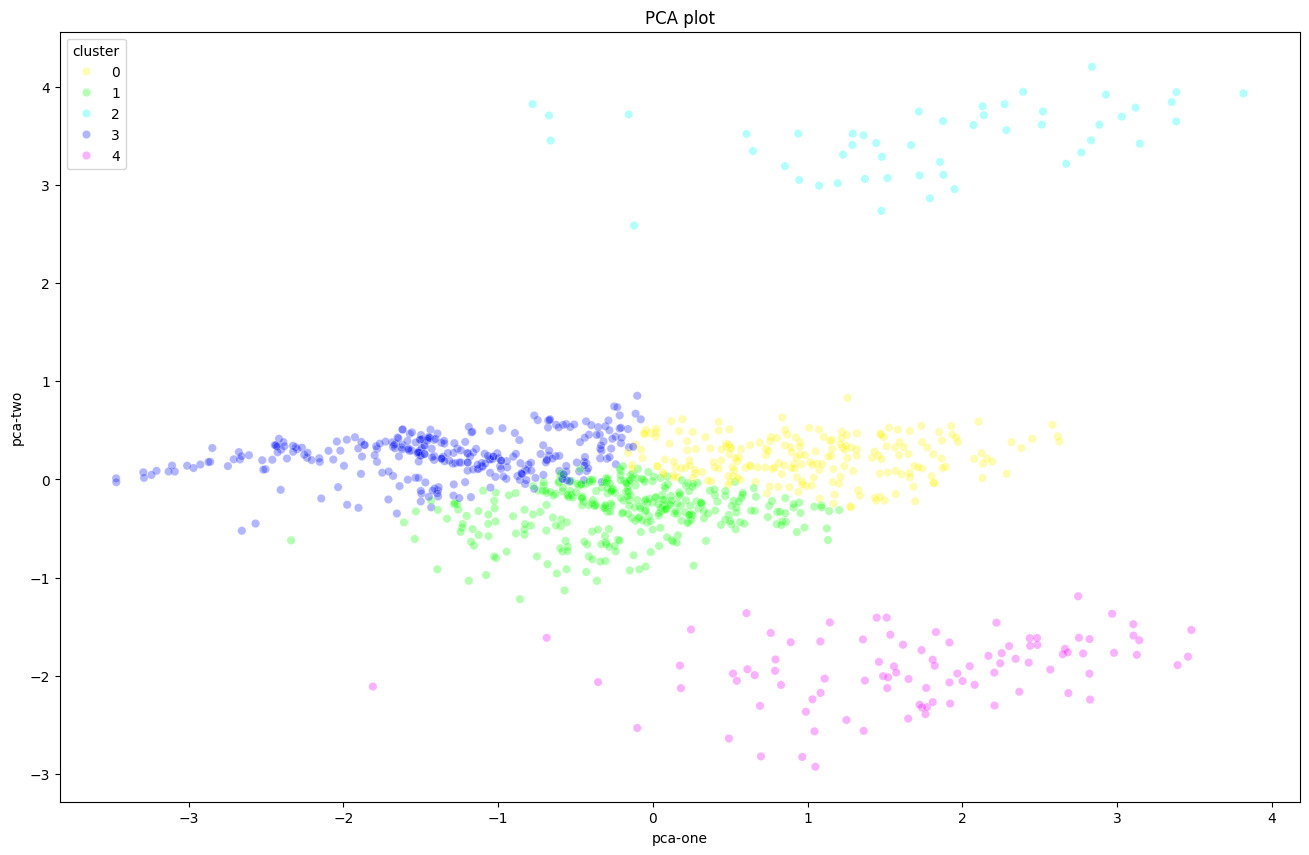

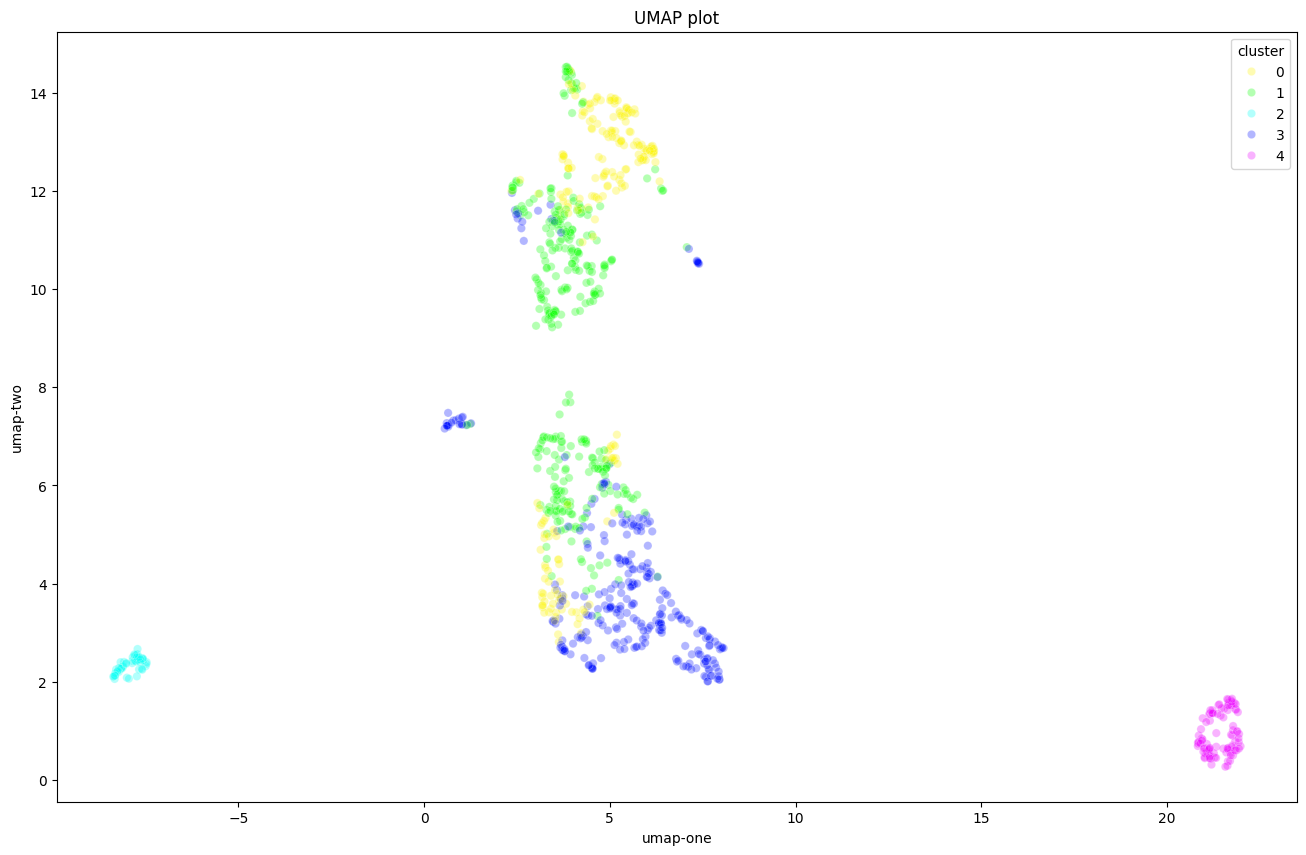

In [ ]:
# Valor optimo segun grafico
k_optimo = 5

# clustering
df_reduced_clustered, df_reduced_scaled_clustered = get_clusters(df_reduced, df_reduced_scaled, model, k_optimo)

# metricas
get_metrics(df_reduced_scaled_clustered, model)

# visualizaciones
plot_PCA(df_reduced_scaled_clustered, output_path + '/pca')
plot_UMAP(df_reduced_scaled_clustered, output_path + '/umap')

# [Lucas]

En la siguiente parte se realiza el entrenamiento con 3 modelos distintos, los cuales buscan el numero optimo de clusters basados en el Silhouette Score.

Silhouette score visualization saved
Metricas para Kmeans
Silhouette Score: 0.1781675141749086
Davies-Bouldin Index: 1.6857823880362495
Calinski-Harabasz Index: 188.12404556174562

Cantidad de datos por cluster:
Cluster 0: 217 datos
Cluster 1: 333 datos
Cluster 2: 50 datos
Cluster 3: 304 datos
Cluster 4: 96 datos


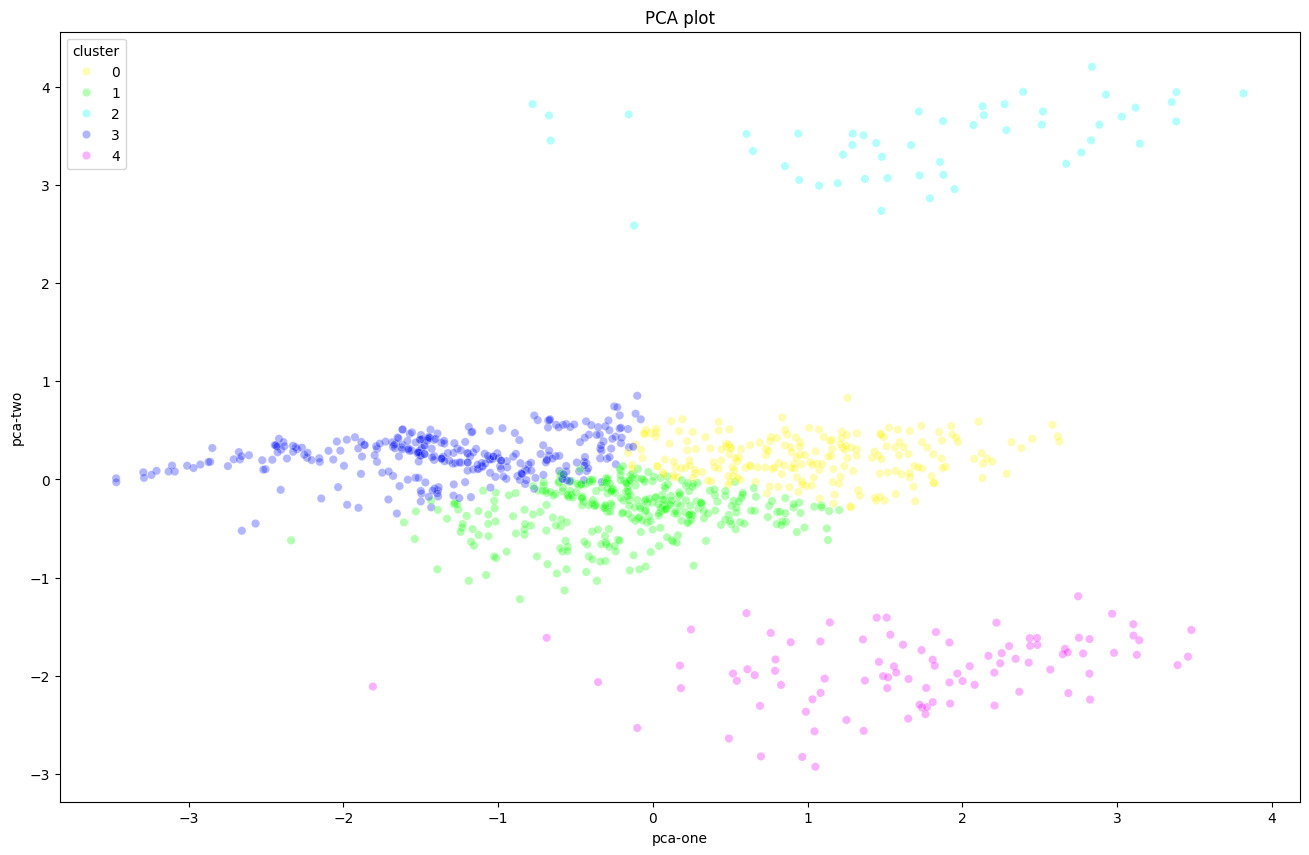

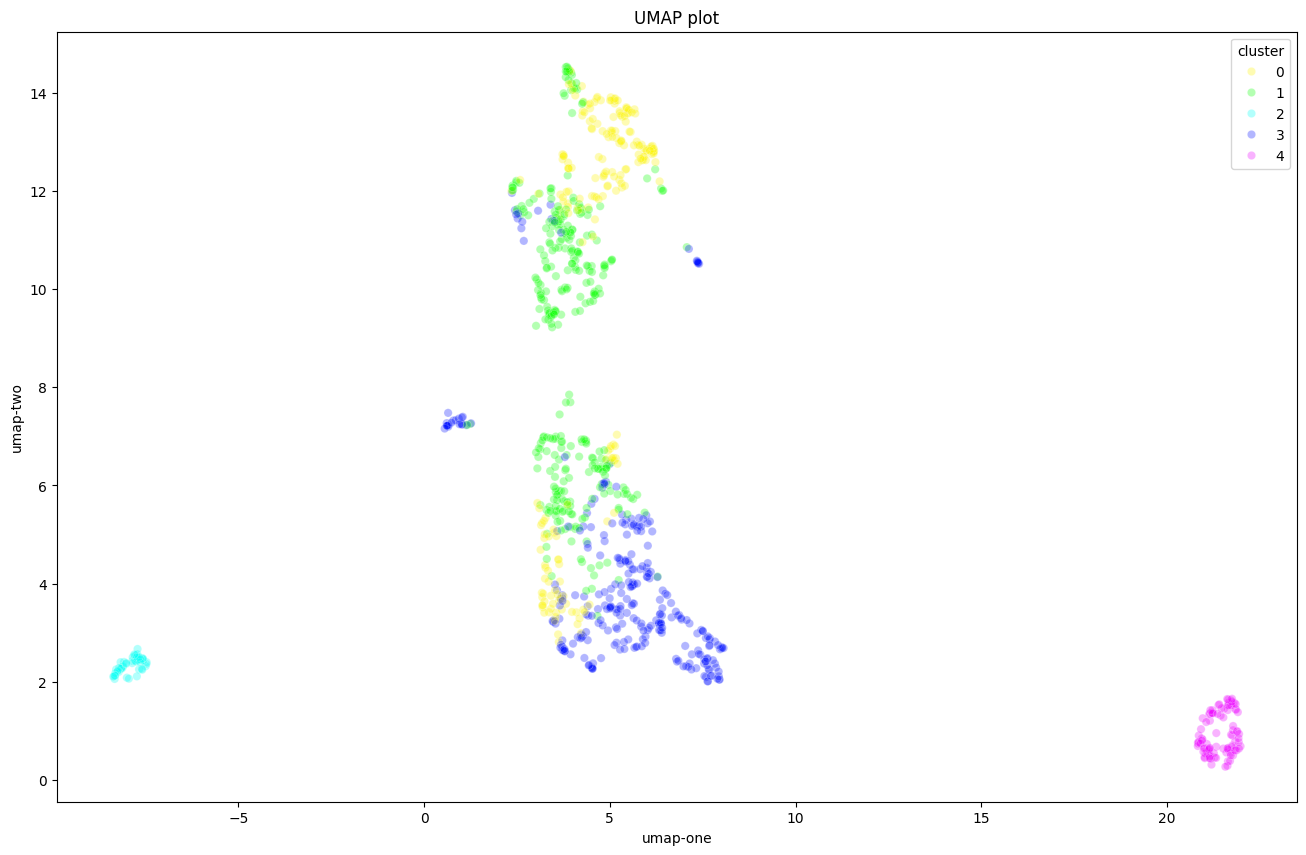

In [ ]:
# Kmeans Clustering Silhouette

model = 'Kmeans'
dataset = 'Reduced'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)


# metodo de silhouete score
k_optimo = silhoutte_method(df = df_reduced_scaled, model_name = model, output_file_path = output_path + '/silhouette.png')

# clustering
df_full_clustered, df_reduced_scaled_clustered = get_clusters(df_full, df_reduced_scaled,model,k_optimo)

# metricas
get_metrics(df_reduced_scaled_clustered, model)

# visualizaciones
plot_PCA(df_reduced_scaled_clustered, output_path + '/pca')
plot_UMAP(df_reduced_scaled_clustered, output_path + '/umap')

# [Benja]

Silhouette score visualization saved
Metricas para Agglomerative
Silhouette Score: 0.3146958332452714
Davies-Bouldin Index: 1.212017247588088
Calinski-Harabasz Index: 174.76369918660453

Cantidad de datos por cluster:
Cluster 0: 856 datos
Cluster 1: 94 datos
Cluster 2: 50 datos


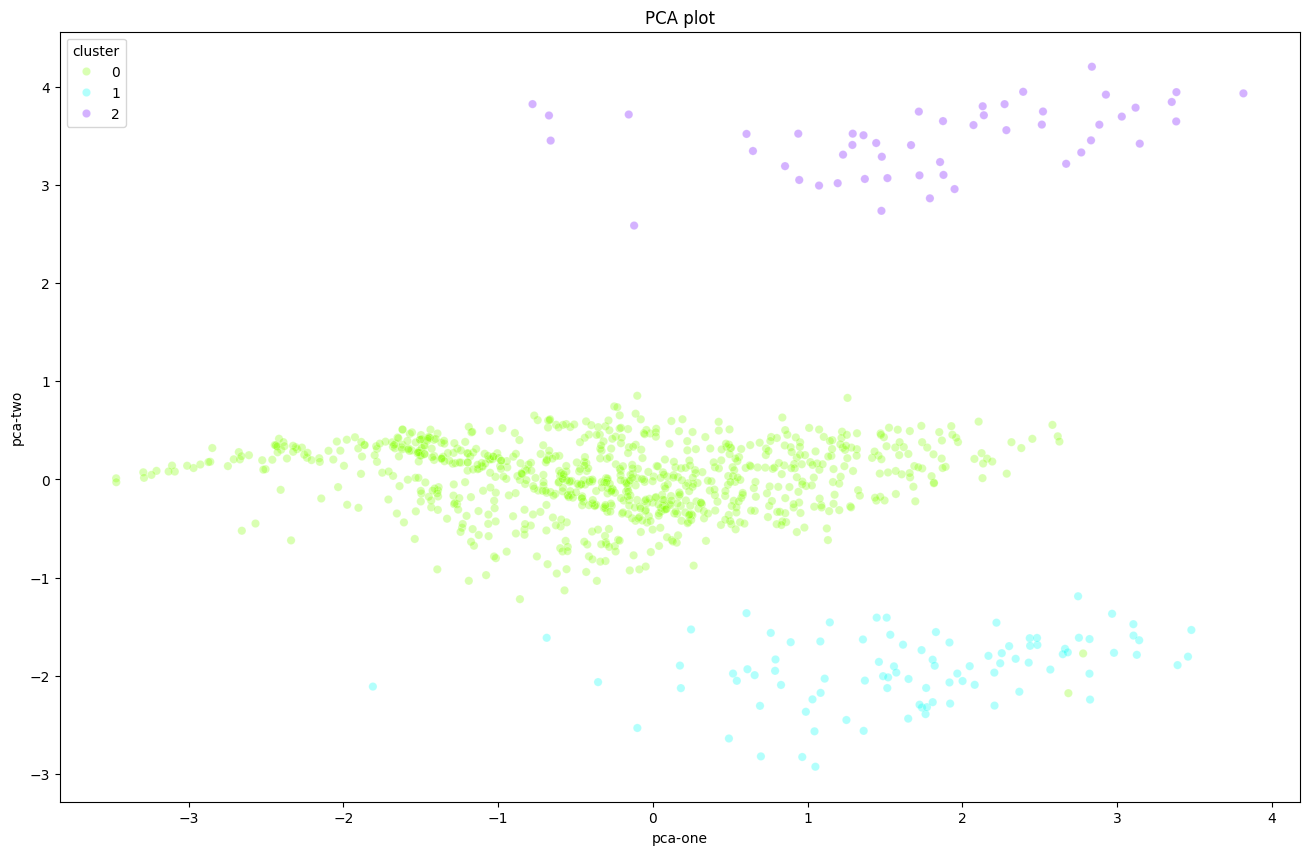

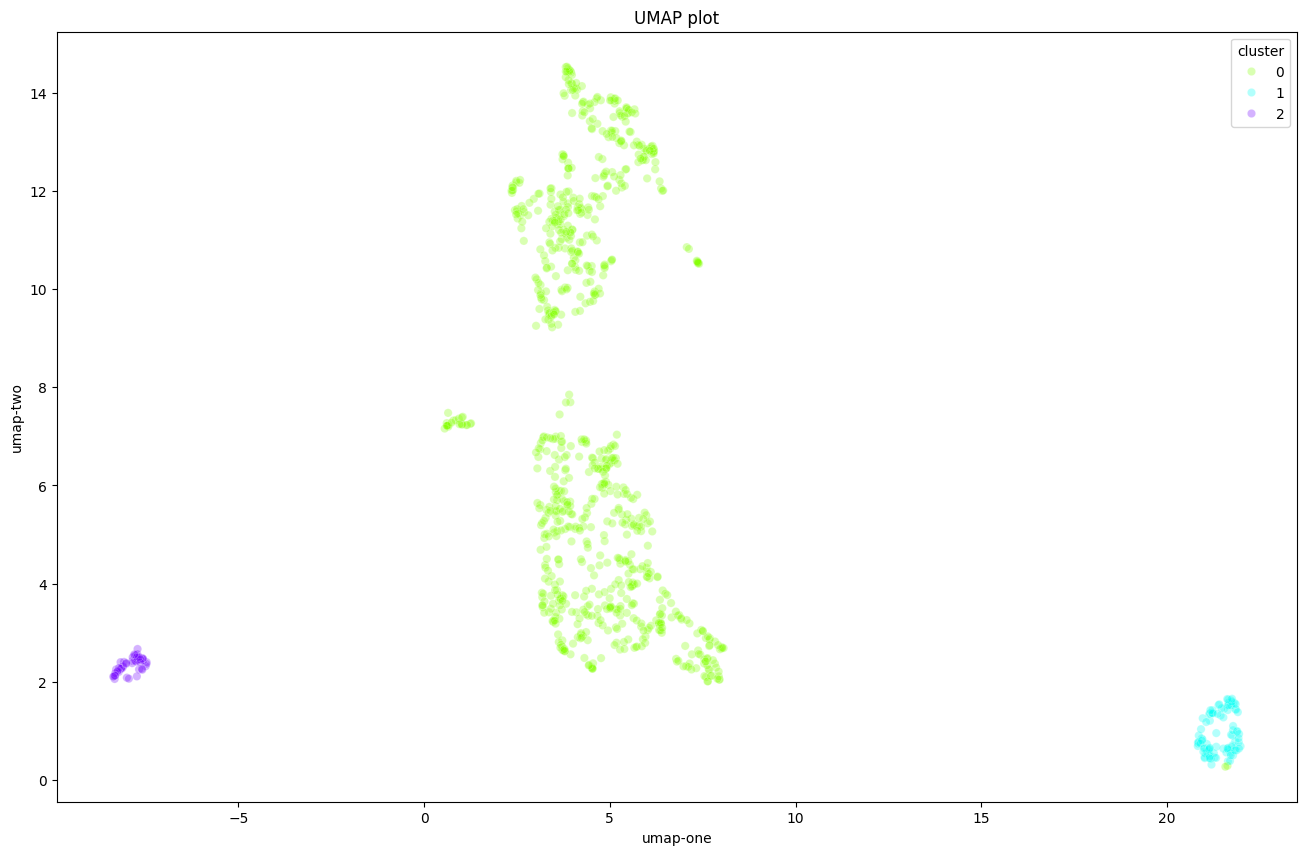

In [ ]:
# Agglomerative Clustering

model = 'Agglomerative'
dataset = 'Reduced'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)


# metodo de silhouete score
k_optimo = silhoutte_method(df = df_reduced_scaled, model_name = model, output_file_path = output_path + '/silhouette.png')

# clustering
df_full_clustered, df_reduced_scaled_clustered = get_clusters(df_full, df_reduced_scaled,model,k_optimo)

# metricas
get_metrics(df_reduced_scaled_clustered, model)

# visualizaciones
plot_PCA(df_reduced_scaled_clustered, output_path + '/pca')
plot_UMAP(df_reduced_scaled_clustered, output_path + '/umap')

# [Benja]

Silhouette score visualization saved
Metricas para GaussianMixture
Silhouette Score: 0.10884886981684523
Davies-Bouldin Index: 2.7183741388720186
Calinski-Harabasz Index: 117.93427937625925

Cantidad de datos por cluster:
Cluster 0: 534 datos
Cluster 1: 466 datos


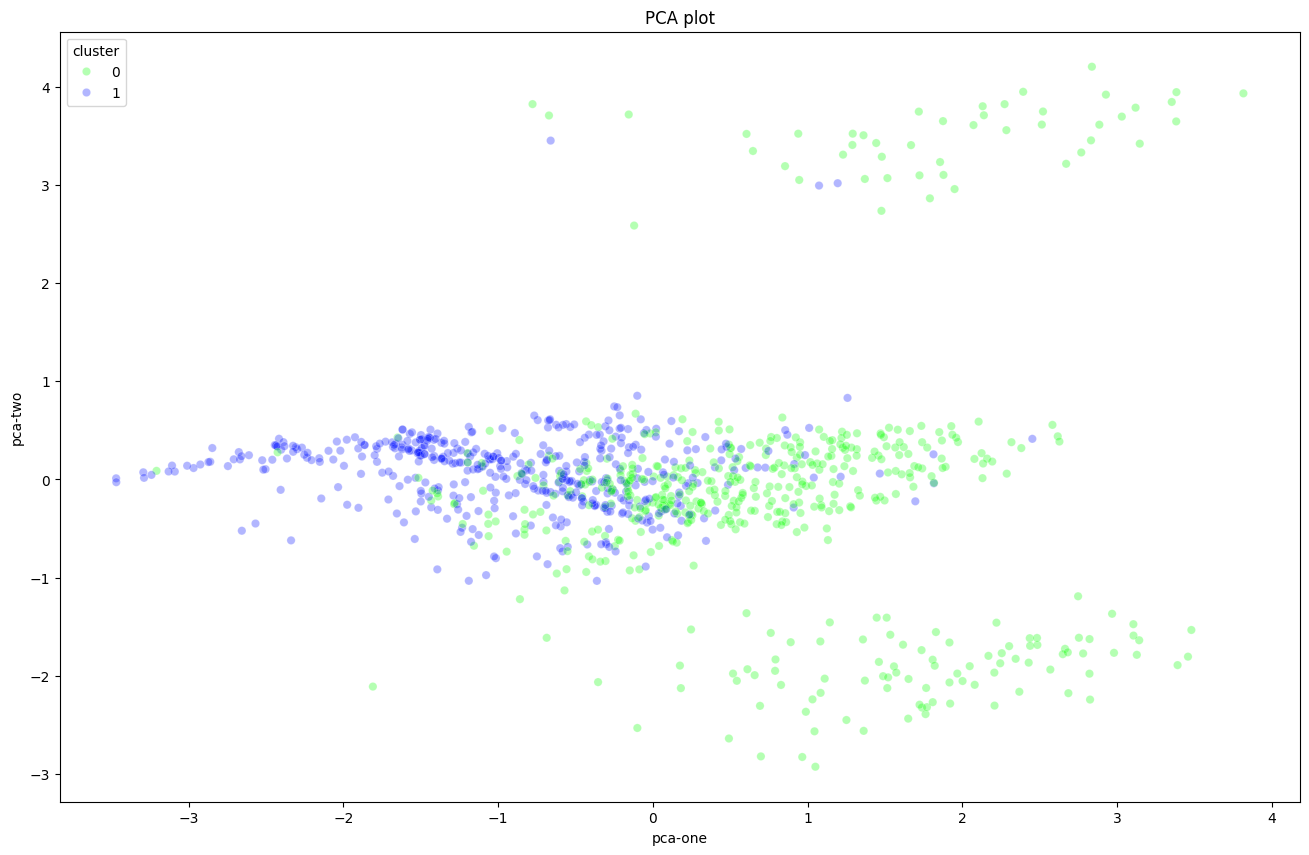

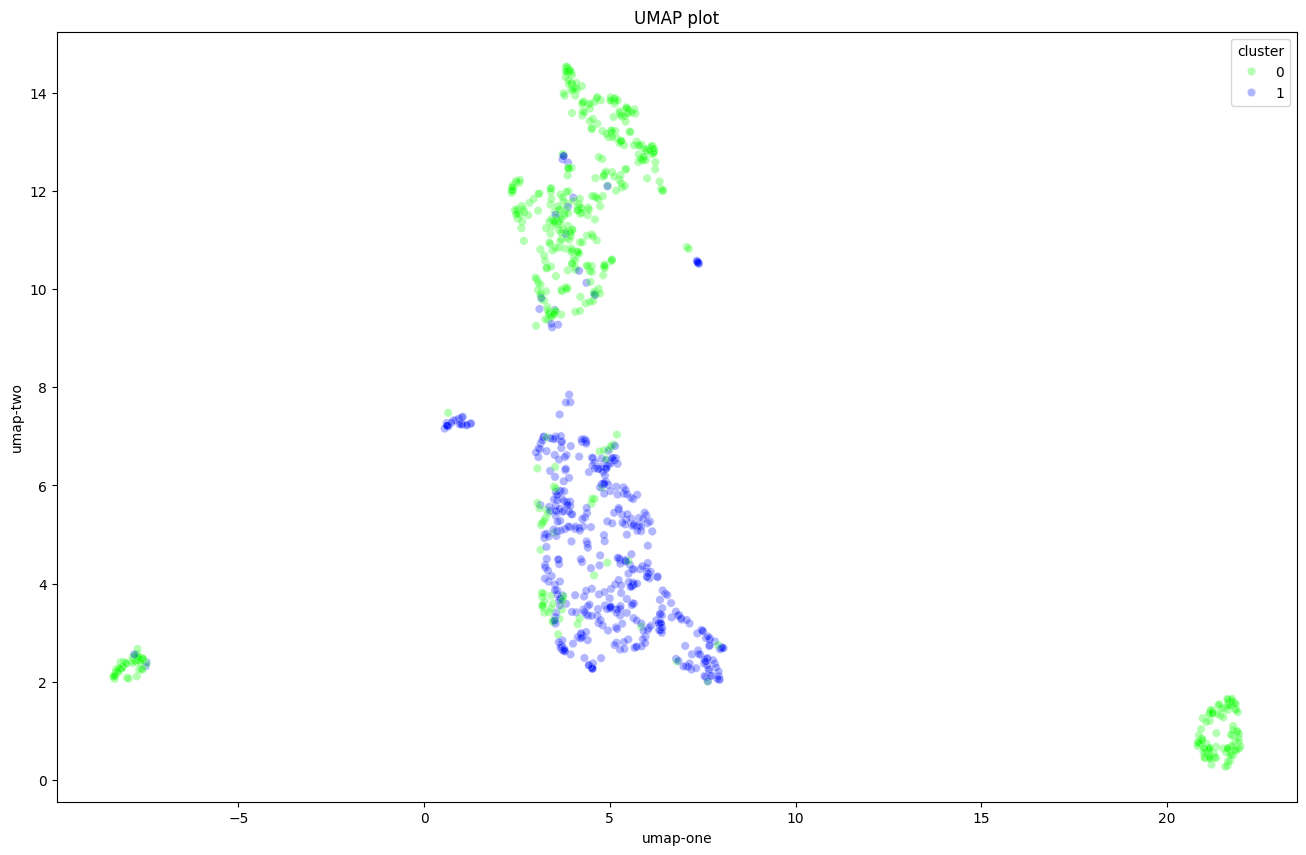

In [ ]:
# GaussianMixture Clustering

model = 'GaussianMixture'
dataset = 'Reduced'
output_path = 'resultados/' + dataset + '_' + model

# folder de salida
if not os.path.exists(output_path):
    os.makedirs(output_path)

# metodo de silhouete score
k_optimo = silhoutte_method(df = df_reduced_scaled, model_name = model, output_file_path = output_path + '/silhouette.png')

# clustering
df_full_clustered, df_reduced_scaled_clustered = get_clusters(df_full, df_reduced_scaled,model,k_optimo)

# metricas
get_metrics(df_reduced_scaled_clustered, model)

# visualizaciones
plot_PCA(df_reduced_scaled_clustered, output_path + '/pca')
plot_UMAP(df_reduced_scaled_clustered, output_path + '/umap')

# [Benja]

Con respecto a las métricas de segmentación y basandonos principalmente en el Silhouette Score, notamos que para el datset reducido el método jerárquico aglomerativo es el que mejor se comporta, con un número de clusters óptimo de 3, identico que el dataset completo. Al visualizar los clusters, notamos que estos están bien definidos y que la pureza es alta.

En conclusión luego de los experimentos realizados, notamos que la eliminación de variables que no se pueden modificar no afecta significativamente la segmentación, ya que el número de clusters óptimos se mantiene constante.

Es importante destacar que en ambos casos el silhouette score es muy bajo, lo que indica que los clusters no están bien definidos, sin embargo la gran mayoria de columnas son categóricas, lo que puede estar afectando esta métrica.

[Benja]